In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import seaborn as sns

**Importing data sets to use**

In [2]:
df = pd.read_csv('wf_final_df.csv')

In [3]:
wf = pd.read_csv('sp500_stock_20_22_close_with_sector_wide_format.csv')

**Getting the april 2023 data**

In [4]:
df_april = pd.read_csv('Data/sp500_stock_april_close_with_sector_wide_format.csv')

In [5]:
df_april.columns.values[2:] = ['days_from_' + str(d).zfill(2) for d in range(1, 62+1)]

In [6]:
df_april_use = df_use = df_april.loc[:, ['symbol', 'days_from_62']]

**Setting the relative closing price for April 2023 compared to Jan 1 2020**

In [7]:
temp_df = wf.set_index('symbol').join(df_april_use.set_index('symbol'), on='symbol', how='left').reset_index()

In [8]:
temp_df['apr_rel_close'] = (temp_df.days_from_62 - temp_df.day_001) / temp_df.day_001

**Getting the final data to use ready and adding the april relative closing price**

In [9]:
df_use = df.copy().drop('Unnamed: 0', axis=1)

In [10]:
df_use['apr_rel_close'] = temp_df.apr_rel_close

**Importing Required Modules**

In [11]:
import statsmodels.formula.api as smf

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

In [13]:
from sklearn.pipeline import Pipeline

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
my_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=101)

In [16]:
from sklearn.preprocessing import OneHotEncoder

In [17]:
from sklearn.compose import ColumnTransformer

In [18]:
from patsy import dmatrices

In [19]:
import time

In [20]:
from sklearn.decomposition import PCA

In [21]:
import pickle

### Neural Network with single hidden layer
**Using trend and seasonal data. Perform PCA and supply the PCA result to neural network**

In [22]:
from sklearn.neural_network import MLPClassifier

In [23]:
nnet_seasonal_days = ['seasonal_week_' + str(d).zfill(3) for d in range(1, 157+1)]

In [24]:
nnet_trend_days = ['trend_week_' + str(d).zfill(3) for d in range(1, 157+1)]

In [25]:
nnet_df = df_use.loc[:, ['sector'] + nnet_seasonal_days + nnet_trend_days].copy()

In [26]:
nnet_df['outcome'] = np.where( df_use.apr_rel_close > df_use.day_756, 'event', 'non-event')

In [27]:
nnet_df.outcome.value_counts(normalize=True)

event        0.542
non-event    0.458
Name: outcome, dtype: float64

In [28]:
nnet_inputs_df = nnet_df.loc[:, ['sector'] + nnet_seasonal_days + nnet_trend_days].copy()

In [29]:
nnet_output_df = nnet_df.loc[:, ['outcome']].copy()

In [30]:
nnet_ytrain = nnet_output_df.outcome.to_numpy().ravel()

In [31]:
nnet_ses_transform = Pipeline(steps=[ ('std_ses', StandardScaler()),
                                      ('pca_ses', PCA()) ])

In [32]:
nnet_trend_transform = Pipeline(steps=[ ('std_trend', StandardScaler()),
                                        ('pca_trend', PCA()) ])

In [33]:
nnet_ses_trend_transform = ColumnTransformer(transformers=[ ('ses_pca', nnet_ses_transform, nnet_seasonal_days),
                                                             ('trend_pca', nnet_trend_transform, nnet_trend_days )])

In [34]:
nnet_pca_transform = Pipeline(steps=[ ('ses_trend_pca', nnet_ses_trend_transform) ])

In [35]:
nnet_cat_input = nnet_inputs_df.select_dtypes('object').columns.to_list()

In [36]:
nnet_cat_transform = Pipeline(steps= [('dummy', OneHotEncoder(drop='first')) ])

In [37]:
nnet_prepo_transform = ColumnTransformer(transformers=[ ('num_inputs', nnet_pca_transform, nnet_seasonal_days + nnet_trend_days),
                                                         ('cat', nnet_cat_transform, nnet_cat_input)])

In [38]:
nnet_wflow = Pipeline(steps=[ ('prepo', nnet_prepo_transform),
                              ('nnet', MLPClassifier(activation='relu',
                                                     solver='sgd',
                                                     batch_size=32,
                                                     max_iter=5001)) ])

In [39]:
nnet_tune_grid = {'prepo__num_inputs__ses_trend_pca__ses_pca__pca_ses__n_components': [10, 50, 90],
                  'prepo__num_inputs__ses_trend_pca__trend_pca__pca_trend__n_components': [10, 50, 90],
                  'nnet__hidden_layer_sizes': [20, 40, 60],
                  'nnet__alpha': np.exp(np.linspace(-9, -1, 11)) }

In [40]:
nnet_search = GridSearchCV(nnet_wflow, nnet_tune_grid, cv=my_cv)

In [41]:
# nnet_t0 = time.time()

# nnet_search_results = nnet_search.fit(nnet_inputs_df, nnet_ytrain)

# nnet_t1 = time.time()

In [42]:
# ( nnet_t1 - nnet_t0 ) / 60

**Save Model**

In [43]:
# pickle.dump(nnet_search_results, open('nnet_final.sav', 'wb'))

**Load Model**

In [44]:
nnet_search_results = pickle.load(open('nnet_final.sav', 'rb'))

In [45]:
nnet_search_results.best_params_

{'nnet__alpha': 0.16529888822158656,
 'nnet__hidden_layer_sizes': 20,
 'prepo__num_inputs__ses_trend_pca__ses_pca__pca_ses__n_components': 90,
 'prepo__num_inputs__ses_trend_pca__trend_pca__pca_trend__n_components': 90}

In [46]:
nnet_search_results.best_score_

0.7046666666666667

**Visualizing the result**

In [47]:
nnet_cv_summary = pd.DataFrame({'alpha': nnet_search_results.cv_results_['param_nnet__alpha'].data.astype('float64'),
                                'hidden_units': nnet_search_results.cv_results_['param_nnet__hidden_layer_sizes'].data.astype('float64'),
                                'mean_test_score': nnet_search_results.cv_results_['mean_test_score'],
                                'std_test_score': nnet_search_results.cv_results_['std_test_score']})

In [48]:
nnet_cv_summary['mean_test_score_se'] = nnet_cv_summary.std_test_score / np.sqrt( my_cv.get_n_splits() )

In [49]:
nnet_cv_summary['log_alpha'] = np.log( nnet_cv_summary.alpha )

In [50]:
nnet_cv_summary.sort_values(['mean_test_score'], ascending=False).head()

,alpha,hidden_units,mean_test_score,std_test_score,mean_test_score_se,log_alpha
286,0.367879,40.0,0.704667,0.038621,0.009972,-1.0
251,0.165299,20.0,0.704667,0.046743,0.012069,-1.8
287,0.367879,40.0,0.704000,0.049369,0.012747,-1.0
285,0.367879,40.0,0.703333,0.049486,0.012777,-1.0
142,0.006738,20.0,0.700667,0.047253,0.012201,-5.0


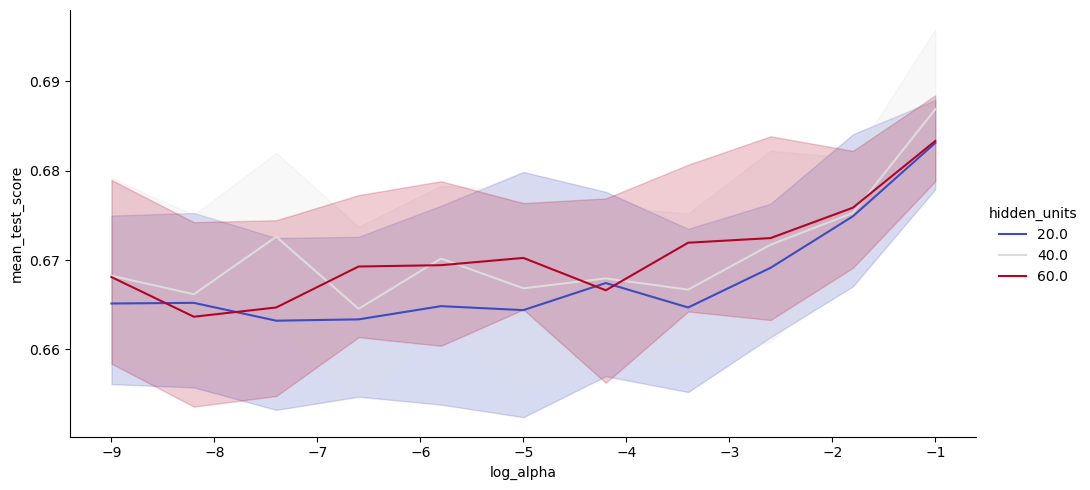

In [51]:
sns.relplot(data=nnet_cv_summary, x='log_alpha', y='mean_test_score', hue='hidden_units',
           kind='line', palette='coolwarm', aspect=2)

plt.show()

### Neural Network with two hidden layer
**Using trend and seasonal data. Perform PCA and supply the PCA result to neural network**

In [52]:
nnet_hidden2_wflow = Pipeline(steps=[ ('prepo', nnet_prepo_transform),
                                      ('nnet', MLPClassifier(activation='relu',
                                                     solver='sgd',
                                                     batch_size=32,
                                                     max_iter=5001)) ])

In [53]:
nnet_hidden2_tune_grid = {'prepo__num_inputs__ses_trend_pca__ses_pca__pca_ses__n_components': [10, 50, 90],
                           'prepo__num_inputs__ses_trend_pca__trend_pca__pca_trend__n_components': [10, 50, 90],
                           'nnet__hidden_layer_sizes': [(5, 5), (15, 5), (30, 5)],
                           'nnet__alpha': np.exp(np.linspace(-9, -1, 11)) }

In [54]:
nnet_hidden2_search = GridSearchCV(nnet_hidden2_wflow, nnet_hidden2_tune_grid, cv=my_cv)

In [55]:
# nnet_hidden2_t0 = time.time()

# nnet_hidden2_search_results = nnet_hidden2_search.fit(nnet_inputs_df, nnet_ytrain)

# nnet_hidden2_t1 = time.time()

In [56]:
# ( nnet_hidden2_t1 - nnet_hidden2_t0 ) / 60

**Save Model**

In [57]:
# pickle.dump(nnet_hidden2_search_results, open('nnet_hidden2_final.sav', 'wb'))

**Load Model**

In [58]:
nnet_hidden2_search_results = pickle.load(open('nnet_hidden2_final.sav', 'rb'))

In [59]:
nnet_hidden2_search_results.best_params_

{'nnet__alpha': 0.36787944117144233,
 'nnet__hidden_layer_sizes': (5, 5),
 'prepo__num_inputs__ses_trend_pca__ses_pca__pca_ses__n_components': 90,
 'prepo__num_inputs__ses_trend_pca__trend_pca__pca_trend__n_components': 90}

In [60]:
nnet_hidden2_search_results.best_score_

0.6939999999999998

**Visualizing the result**

In [61]:
nnet_hidden2_cv_summary = pd.DataFrame({'alpha': nnet_hidden2_search_results.cv_results_['param_nnet__alpha'].data.astype('float64'),
                                        'hidden_units': nnet_hidden2_search_results.cv_results_['param_nnet__hidden_layer_sizes'].data.astype('object'),
                                        'mean_test_score': nnet_hidden2_search_results.cv_results_['mean_test_score'],
                                        'std_test_score': nnet_hidden2_search_results.cv_results_['std_test_score']})   

In [62]:
nnet_hidden2_cv_summary['mean_test_score_se'] = nnet_hidden2_cv_summary.std_test_score / np.sqrt( my_cv.get_n_splits() )

In [63]:
nnet_hidden2_cv_summary['log_alpha'] = np.log( nnet_hidden2_cv_summary.alpha )

In [64]:
nnet_hidden2_cv_summary.sort_values(['mean_test_score'], ascending=False).head()

,alpha,hidden_units,mean_test_score,std_test_score,mean_test_score_se,log_alpha
278,0.367879,"(5, 5)",0.694000,0.048826,0.012607,-1.0
71,0.000611,"(15, 5)",0.693333,0.036636,0.009459,-7.4
133,0.003028,"(30, 5)",0.693333,0.051854,0.013389,-5.8
215,0.033373,"(30, 5)",0.692667,0.047112,0.012164,-3.4
295,0.367879,"(30, 5)",0.692667,0.050262,0.012977,-1.0


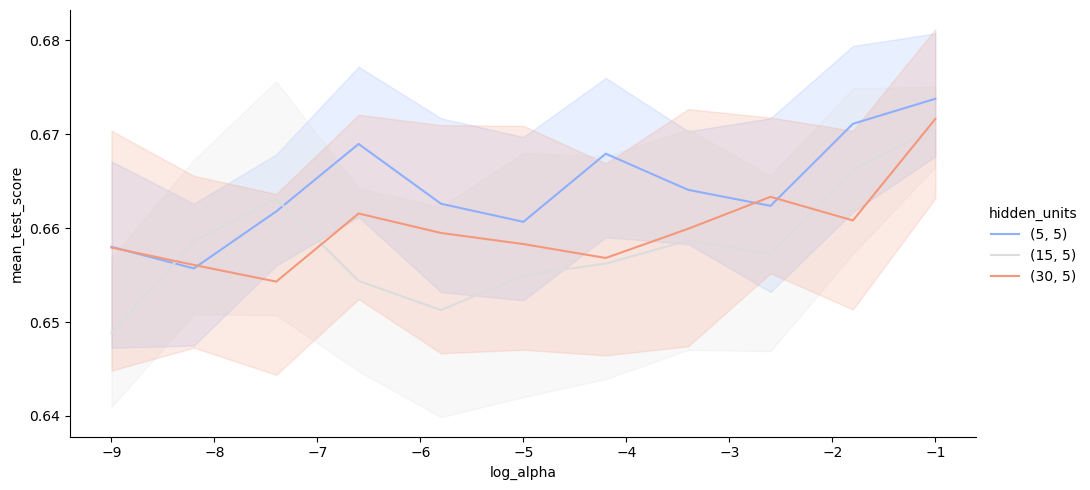

In [65]:
sns.relplot(data=nnet_hidden2_cv_summary, x='log_alpha', y='mean_test_score', hue='hidden_units',
           kind='line', palette='coolwarm', aspect=2)

plt.show()

### Support Vector Machine (SVM)

In [66]:
from sklearn.svm import SVC

In [67]:
svm_seasonal_days = ['seasonal_week_' + str(d).zfill(3) for d in range(1, 157+1)]

In [68]:
svm_trend_days = ['trend_week_' + str(d).zfill(3) for d in range(1, 157+1)]

In [69]:
svm_df = df_use.loc[:, ['sector'] + svm_seasonal_days + svm_trend_days].copy()

In [70]:
svm_df['outcome'] = np.where( df_use.apr_rel_close > df_use.day_756, 'event', 'non-event')

In [71]:
svm_df.outcome.value_counts(normalize=True)

event        0.542
non-event    0.458
Name: outcome, dtype: float64

In [72]:
svm_inputs_df = svm_df.loc[:, ['sector'] + svm_seasonal_days + svm_trend_days].copy()

In [73]:
svm_output_df = svm_df.loc[:, ['outcome']].copy()

In [74]:
svm_ytrain = svm_output_df.outcome.to_numpy().ravel()

In [75]:
svm_ses_transform = Pipeline(steps=[ ('std_ses', StandardScaler()),
                                     ('pca_ses', PCA()) ])

In [76]:
svm_trend_transform = Pipeline(steps=[ ('std_trend', StandardScaler()),
                                       ('pca_trend', PCA()) ])

In [77]:
svm_ses_trend_transform = ColumnTransformer(transformers=[ ('ses_pca', svm_ses_transform, svm_seasonal_days),
                                                           ('trend_pca', svm_trend_transform, svm_trend_days )])

In [78]:
svm_pca_transform = Pipeline(steps=[ ('ses_trend_pca', svm_ses_trend_transform) ])

In [79]:
svm_cat_input = svm_inputs_df.select_dtypes('object').columns.to_list()

In [80]:
svm_cat_transform = Pipeline(steps= [('dummy', OneHotEncoder(drop='first')) ])

In [81]:
svm_prepo_transform = ColumnTransformer(transformers=[ ('num_inputs', svm_pca_transform, svm_seasonal_days + svm_trend_days),
                                                       ('cat', svm_cat_transform, svm_cat_input)])

In [82]:
svm_wflow = Pipeline(steps=[ ('prepo', svm_prepo_transform),
                             ('svm', SVC(gamma='scale', kernel='rbf', probability=True)) ])

In [83]:
svm_tune_grid = {'prepo__num_inputs__ses_trend_pca__ses_pca__pca_ses__n_components': [10, 20, 40, 80],
                  'prepo__num_inputs__ses_trend_pca__trend_pca__pca_trend__n_components': [10, 20, 40, 80],
                  'svm__C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10, 50, 100, 500, 1000] }

In [84]:
svm_search = GridSearchCV(svm_wflow, svm_tune_grid, cv=my_cv)

In [85]:
# svm_t0 = time.time()

# svm_search_results = svm_search.fit(svm_inputs_df, svm_ytrain)

# svm_t1 = time.time()

In [86]:
# ( svm_t1 - svm_t0 ) / 60

**Save Model**

In [87]:
# pickle.dump(svm_search_results, open('svm_final.sav', 'wb'))

**Load Model**

In [88]:
svm_search_results = pickle.load(open('svm_final.sav', 'rb'))

In [89]:
svm_search_results.best_params_

{'prepo__num_inputs__ses_trend_pca__ses_pca__pca_ses__n_components': 80,
 'prepo__num_inputs__ses_trend_pca__trend_pca__pca_trend__n_components': 10,
 'svm__C': 5.0}

In [90]:
svm_search_results.best_score_

0.6880000000000001

**Visualizing the result**

In [91]:
svm_cv_summary = pd.DataFrame({'C': svm_search_results.cv_results_['param_svm__C'].data.astype('float64'),
                               'ses_pca': svm_search_results.cv_results_['param_prepo__num_inputs__ses_trend_pca__ses_pca__pca_ses__n_components'].data.astype('float64'),
                               'trend_pca': svm_search_results.cv_results_['param_prepo__num_inputs__ses_trend_pca__trend_pca__pca_trend__n_components'].data.astype('float64'),
                               'mean_test_score': svm_search_results.cv_results_['mean_test_score'],
                               'std_test_score': svm_search_results.cv_results_['std_test_score']})

In [92]:
svm_cv_summary['mean_test_score_se'] = svm_cv_summary.std_test_score / np.sqrt( my_cv.get_n_splits() )

In [93]:
svm_cv_summary['log_C'] = np.log( svm_cv_summary.C )

In [94]:
svm_cv_summary.sort_values(['mean_test_score'], ascending=False).head()

,C,ses_pca,trend_pca,mean_test_score,std_test_score,mean_test_score_se,log_C
202,5.0,80.0,80.0,0.688000,0.049017,0.012656,1.609438
163,5.0,80.0,10.0,0.688000,0.049017,0.012656,1.609438
176,5.0,80.0,20.0,0.688000,0.049017,0.012656,1.609438
189,5.0,80.0,40.0,0.688000,0.049017,0.012656,1.609438
111,5.0,40.0,10.0,0.686667,0.048671,0.012567,1.609438


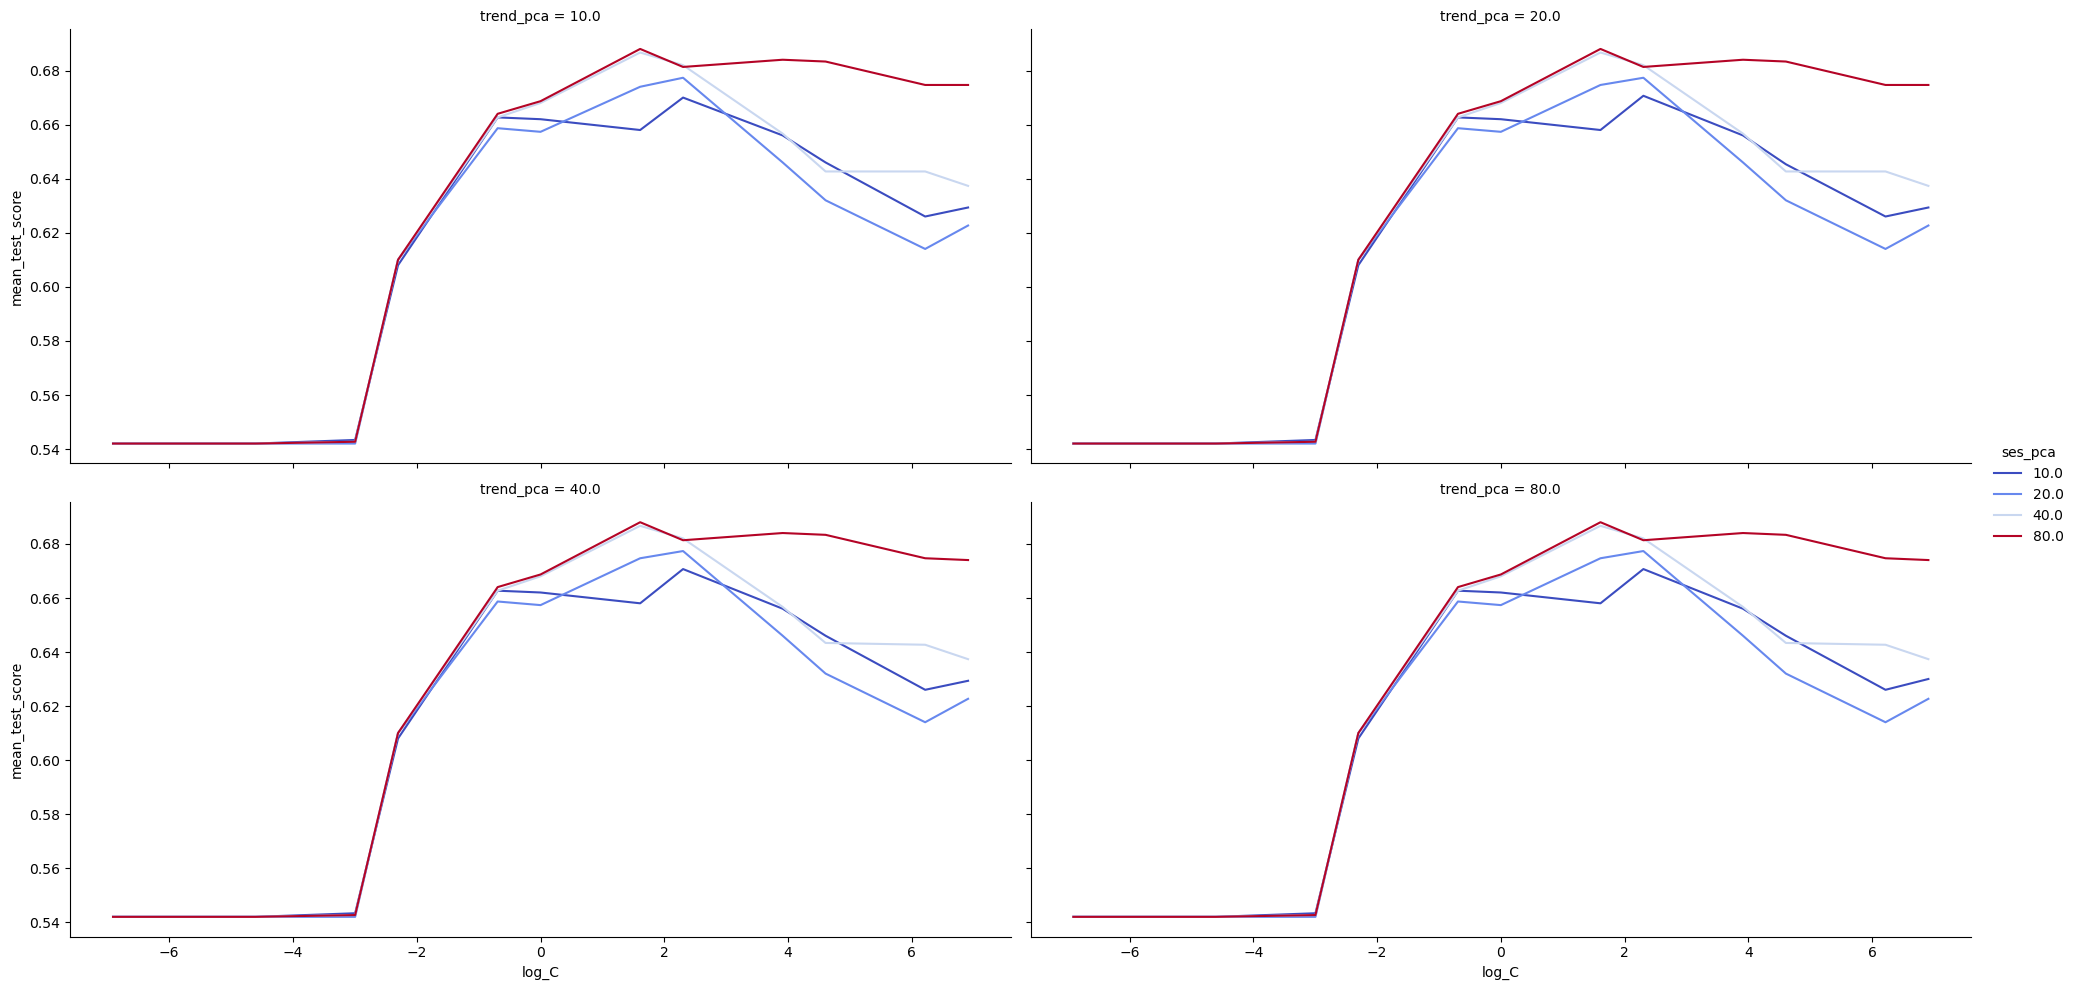

In [95]:
sns.relplot(data=svm_cv_summary, x='log_C', y='mean_test_score', hue='ses_pca',
            col='trend_pca', col_wrap=2,
           kind='line', palette='coolwarm', aspect=2)

plt.show()

### Random Forest

In [96]:
from sklearn.ensemble import RandomForestClassifier

In [97]:
rf_seasonal_days = ['seasonal_week_' + str(d).zfill(3) for d in range(1, 157+1)]

In [98]:
rf_trend_days = ['trend_week_' + str(d).zfill(3) for d in range(1, 157+1)]

In [99]:
rf_df = df_use.loc[:, ['sector'] + rf_seasonal_days + rf_trend_days].copy()

In [100]:
rf_df['outcome'] = np.where( df_use.apr_rel_close > df_use.day_756, 'event', 'non-event')

In [101]:
rf_df.outcome.value_counts(normalize=True)

event        0.542
non-event    0.458
Name: outcome, dtype: float64

In [102]:
rf_inputs_df = rf_df.loc[:, ['sector'] + rf_seasonal_days + rf_trend_days].copy()

In [103]:
rf_output_df = rf_df.loc[:, ['outcome']].copy()

In [104]:
rf_ytrain = rf_output_df.outcome.to_numpy().ravel()

In [105]:
rf_num_transform = Pipeline(steps=[ ('std', StandardScaler()) ])

In [106]:
rf_cat_input = rf_inputs_df.select_dtypes('object').columns.to_list()

In [107]:
rf_cat_transform = Pipeline(steps=[ ('dummy', OneHotEncoder(drop='first')) ])

In [108]:
rf_prepo_transform = ColumnTransformer(transformers=[ ('num', rf_num_transform, rf_seasonal_days + rf_trend_days),
                                                      ('cat', rf_cat_transform, rf_cat_input) ])

In [109]:
rf_wflow = Pipeline(steps=[ ('prepo', rf_prepo_transform),
                            ('rf', RandomForestClassifier(n_estimators=500)) ])

In [110]:
rf_tune_grid = {'rf__max_features': [10, 20, 40, 80, 160, 320]}

In [111]:
rf_search = GridSearchCV(rf_wflow, rf_tune_grid, cv=my_cv)

In [112]:
# rf_t0 = time.time()

# rf_search_results = rf_search.fit(rf_inputs_df, rf_ytrain)

# rf_t1 = time.time()

In [113]:
# (rf_t1 - rf_t0) / 60

**Save Model**

In [114]:
# pickle.dump(rf_search_results, open('rf_final.sav', 'wb'))

**Load Model**

In [115]:
rf_search_results = pickle.load(open('rf_final.sav', 'rb'))

In [116]:
rf_search_results.best_params_

{'rf__max_features': 10}

In [117]:
rf_search_results.best_score_

0.6940000000000003

**Visualizing the result**

In [118]:
rf_cv_summary = pd.DataFrame({'max_features': rf_search_results.cv_results_['param_rf__max_features'].data.astype('float64'),
                              'mean_test_score': rf_search_results.cv_results_['mean_test_score'],
                              'std_test_score': rf_search_results.cv_results_['std_test_score']})   

In [119]:
rf_cv_summary['mean_test_score_se'] = rf_cv_summary.std_test_score / np.sqrt( my_cv.get_n_splits() )

In [120]:
rf_cv_summary.sort_values(['mean_test_score'], ascending=False).head()

,max_features,mean_test_score,std_test_score,mean_test_score_se
0,10.0,0.694000,0.053392,0.013786
1,20.0,0.691333,0.057488,0.014843
3,80.0,0.689333,0.056388,0.014559
2,40.0,0.684000,0.052637,0.013591
4,160.0,0.682667,0.053350,0.013775


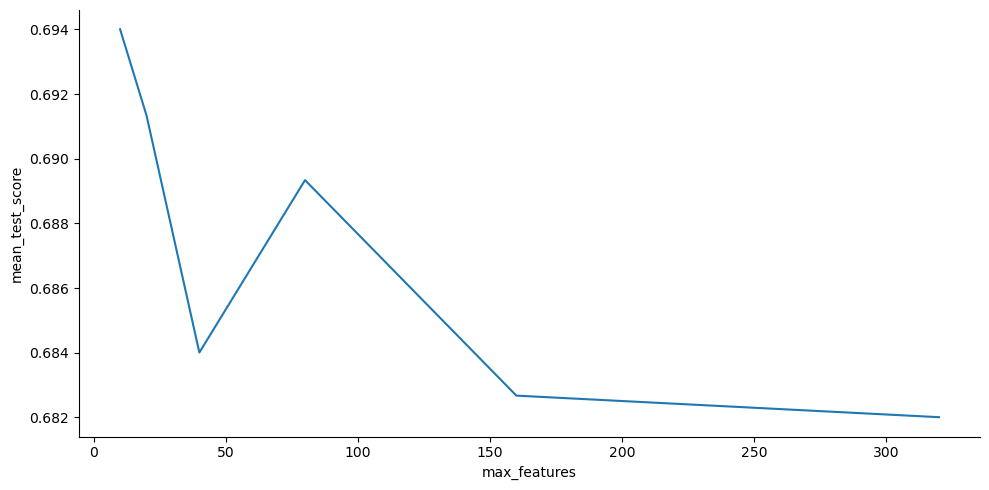

In [121]:
sns.relplot(data=rf_cv_summary, x='max_features', y='mean_test_score',
           kind='line', aspect=2)

plt.show()

### Gradient Boosted Trees

In [122]:
from sklearn.ensemble import GradientBoostingClassifier

In [123]:
gbm_seasonal_days = ['seasonal_week_' + str(d).zfill(3) for d in range(1, 157+1)]

In [124]:
gbm_trend_days = ['trend_week_' + str(d).zfill(3) for d in range(1, 157+1)]

In [125]:
gbm_df = df_use.loc[:, ['sector'] + gbm_seasonal_days + gbm_trend_days].copy()

In [126]:
gbm_df['outcome'] = np.where( df_use.apr_rel_close > df_use.day_756, 'event', 'non-event')

In [127]:
gbm_df.outcome.value_counts(normalize=True)

event        0.542
non-event    0.458
Name: outcome, dtype: float64

In [128]:
gbm_inputs_df = gbm_df.loc[:, ['sector'] + gbm_seasonal_days + gbm_trend_days].copy()

In [129]:
gbm_output_df = gbm_df.loc[:, ['outcome']].copy()

In [130]:
gbm_ytrain = gbm_output_df.outcome.to_numpy().ravel()

In [131]:
gbm_num_transform = Pipeline(steps=[ ('std', StandardScaler()) ])

In [132]:
gbm_cat_input = gbm_inputs_df.select_dtypes('object').columns.to_list()

In [133]:
gbm_cat_transform = Pipeline(steps=[ ('dummy', OneHotEncoder(drop='first')) ])

In [134]:
gbm_prepo_transform = ColumnTransformer(transformers=[ ('num', gbm_num_transform, gbm_seasonal_days + gbm_trend_days),
                                                       ('cat', gbm_cat_transform, gbm_cat_input) ])

In [135]:
gbm_wflow = Pipeline(steps=[ ('prepo', gbm_prepo_transform),
                             ('gbm', GradientBoostingClassifier()) ])

In [136]:
gbm_tune_grid = {'gbm__learning_rate': [0.01, 0.05, 0.1, 0.25],
                 'gbm__n_estimators': [100, 200, 300, 400, 500, 1000],
                 'gbm__max_depth': [1, 3, 5]}

In [137]:
gbm_search = GridSearchCV(gbm_wflow, gbm_tune_grid, cv=my_cv)

In [138]:
# gbm_t0 = time.time()

# gbm_search_results = gbm_search.fit(gbm_inputs_df, gbm_ytrain)

# gbm_t1 = time.time()

In [139]:
# (gbm_t1 - gbm_t0) / 60

**Save Model**

In [140]:
# pickle.dump(gbm_search_results, open('gbm_final.sav', 'wb'))

**Load Model**

In [141]:
gbm_search_results = pickle.load(open('gbm_final.sav', 'rb'))

In [142]:
gbm_search_results.best_params_

{'gbm__learning_rate': 0.05, 'gbm__max_depth': 5, 'gbm__n_estimators': 200}

In [143]:
gbm_search_results.best_score_

0.6926666666666667

**Visualizing the result**

In [144]:
gbm_cv_summary = pd.DataFrame({'learning_rate': gbm_search_results.cv_results_['param_gbm__learning_rate'].data.astype('float64'),
                               'n_estimators': gbm_search_results.cv_results_['param_gbm__n_estimators'].data.astype('float64'),
                               'max_depth': gbm_search_results.cv_results_['param_gbm__max_depth'].data.astype('float64'),
                               'mean_test_score': gbm_search_results.cv_results_['mean_test_score'],
                               'std_test_score': gbm_search_results.cv_results_['std_test_score']})

In [145]:
gbm_cv_summary['mean_test_score_se'] = gbm_cv_summary.std_test_score / np.sqrt( my_cv.get_n_splits() )

In [146]:
gbm_cv_summary.sort_values(['mean_test_score'], ascending=False).head()

,learning_rate,n_estimators,max_depth,mean_test_score,std_test_score,mean_test_score_se
68,0.25,300.0,5.0,0.692667,0.046970,0.012128
31,0.05,200.0,5.0,0.692667,0.055554,0.014344
54,0.25,100.0,1.0,0.690000,0.052915,0.013663
53,0.10,1000.0,5.0,0.688000,0.043848,0.011322
26,0.05,300.0,3.0,0.687333,0.047814,0.012346


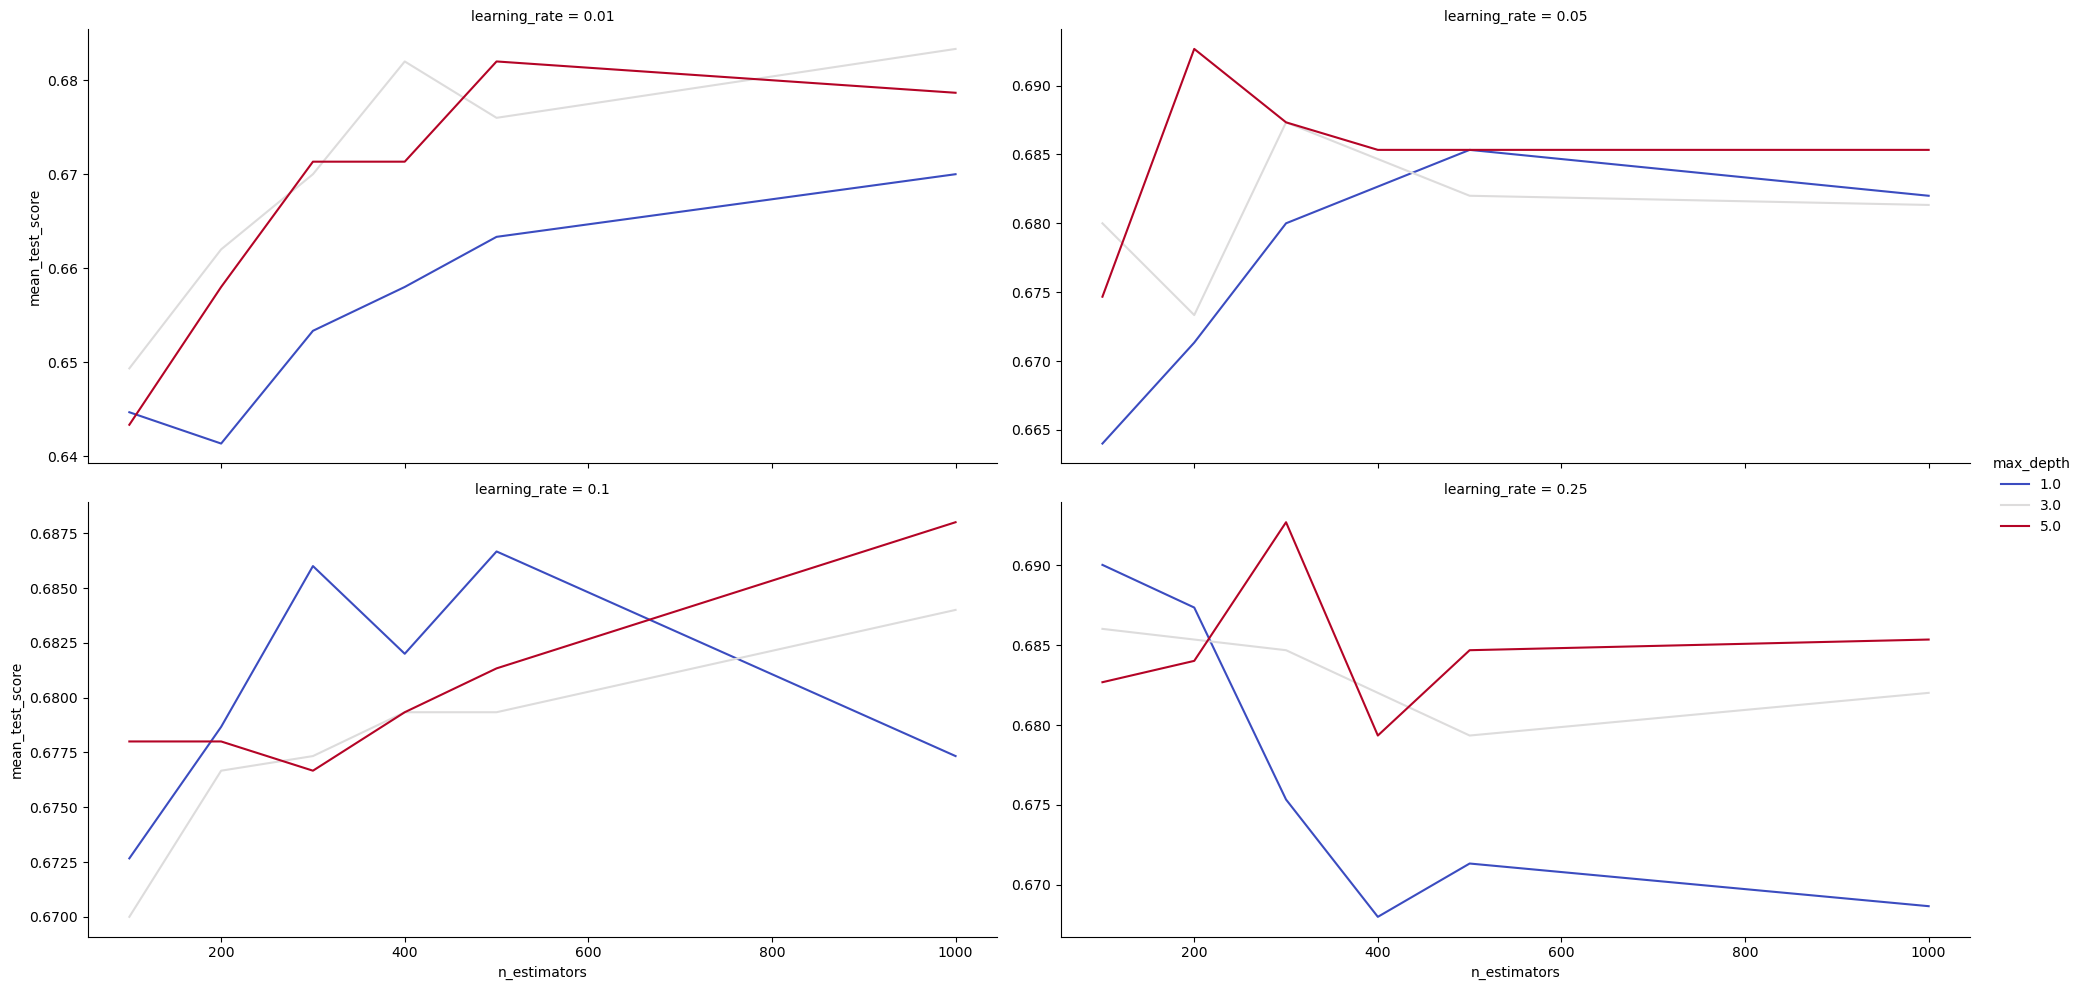

In [147]:
sns.relplot(data=gbm_cv_summary, x='n_estimators', y='mean_test_score', hue='max_depth',
            col='learning_rate', col_wrap=2, facet_kws={'sharey':False},
           kind='line', palette='coolwarm', aspect=2)

plt.show()

### Compare all models

In [148]:
def extract_model_performance(a_mod, a_name, num_folds):
    res = pd.DataFrame({'mean_test_score': a_mod.cv_results_['mean_test_score'],
                        'std_test_score': a_mod.cv_results_['std_test_score']})
    
    res['mean_test_score_se'] = res.std_test_score / np.sqrt( num_folds )
    
    res['model_name'] = a_name
    
    res.drop(['std_test_score'], axis=1, inplace=True)
    
    res_best = res.loc[ res.mean_test_score == res.mean_test_score.max(), :].copy()
    
    res_best.drop(res_best.index.to_list()[1:], axis=0, inplace=True)
    
    return res_best

In [149]:
nonlinear_best = pd.concat([extract_model_performance(nnet_search_results, 'NNET', my_cv.get_n_splits()),
                            extract_model_performance(nnet_hidden2_search_results, 'NNET 2-HIDDEN', my_cv.get_n_splits()),
                            extract_model_performance(svm_search_results, 'SVM', my_cv.get_n_splits()),
                            extract_model_performance(rf_search_results, 'RF', my_cv.get_n_splits()),
                            extract_model_performance(gbm_search_results, 'GBM', my_cv.get_n_splits()) ])

In [150]:
nonlinear_best

,mean_test_score,mean_test_score_se,model_name
251,0.704667,0.012069,NNET
278,0.694000,0.012607,NNET 2-HIDDEN
163,0.688000,0.012656,SVM
0,0.694000,0.013786,RF
31,0.692667,0.014344,GBM


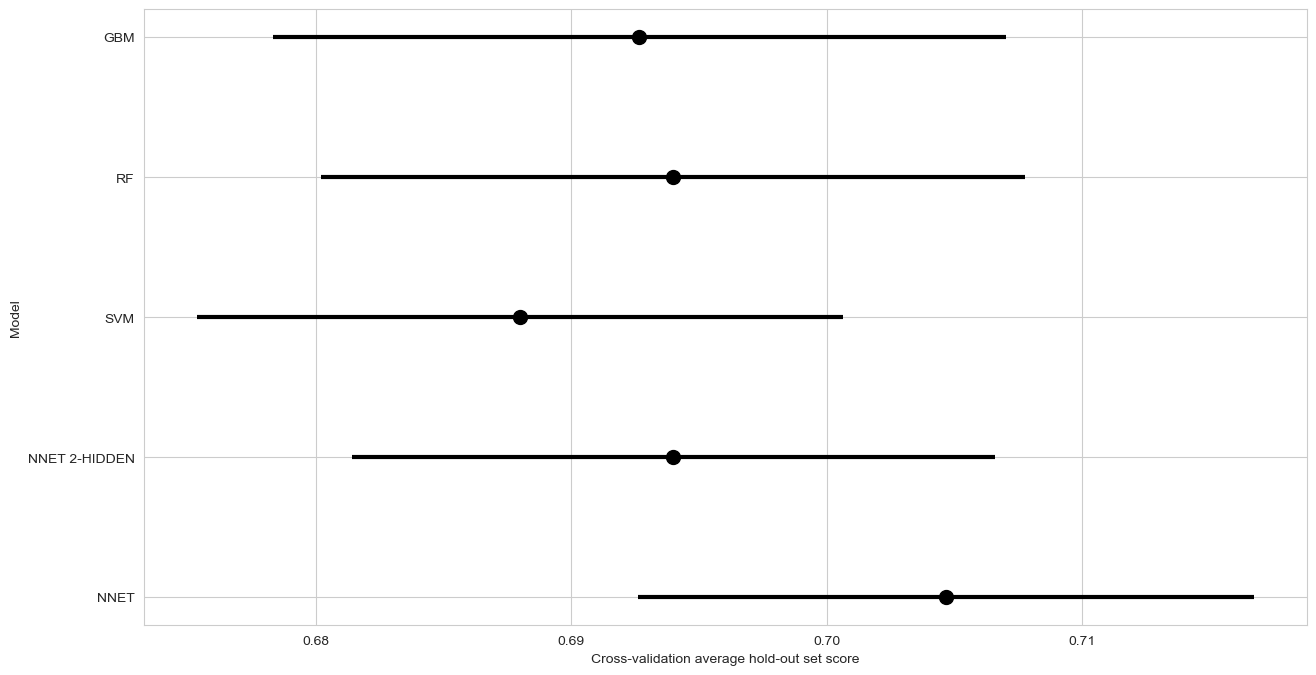

In [151]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(15, 8))

ax.errorbar(y = nonlinear_best.model_name,
            x = nonlinear_best.mean_test_score,
            xerr = nonlinear_best.mean_test_score_se,
            fmt = 'o', color = 'black', ecolor = 'black', 
            elinewidth=3, ms=10)

ax.set_xlabel('Cross-validation average hold-out set score')
ax.set_ylabel('Model')

plt.show()

### Prediction

In [152]:
pred_grid = pd.read_csv('pred_grid.csv')

In [153]:
pred_grid = pred_grid.drop('Unnamed: 0', axis=1).copy()

In [154]:
pred_grid_copy = pred_grid.drop('hclust_11', axis=1)

In [155]:
pred_grid_copy

,seasonal_week_001,seasonal_week_002,seasonal_week_003,seasonal_week_004,seasonal_week_005,seasonal_week_006,seasonal_week_007,seasonal_week_008,seasonal_week_009,seasonal_week_010,...,trend_week_149,trend_week_150,trend_week_151,trend_week_152,trend_week_153,trend_week_154,trend_week_155,trend_week_156,trend_week_157,sector
0,0.145409,0.166053,0.172162,0.158146,0.104971,0.132933,0.148344,0.138148,0.032057,0.034105,...,0.365631,0.358863,0.352078,0.345279,0.338465,0.331637,0.324796,0.317943,0.311077,Financials
1,0.113496,0.123134,0.135175,0.130316,0.102843,0.126861,0.137408,0.123490,0.013777,0.027556,...,-0.665102,-0.670022,-0.674937,-0.679844,-0.684745,-0.689638,-0.694523,-0.699401,-0.704270,Financials
2,0.115009,0.106604,0.132549,0.145650,0.125024,0.147705,0.182848,0.178218,0.050962,0.074792,...,0.088940,0.085498,0.082060,0.078627,0.075199,0.071776,0.068359,0.064948,0.061542,Financials
3,0.061015,0.058983,0.095359,0.113674,0.115806,0.114625,0.131234,0.126915,0.001522,0.067715,...,1.483049,1.485919,1.488752,1.491550,1.494312,1.497042,1.499739,1.502404,1.505040,Financials
4,-0.173275,-0.139467,-0.127519,-0.160604,-0.197421,-0.074450,-0.053298,-0.050630,-0.100797,-0.052430,...,0.455677,0.456161,0.456635,0.457099,0.457553,0.457998,0.458434,0.458861,0.459279,Financials
5,0.044785,0.113885,0.072256,0.059157,-0.029451,-0.022872,0.031471,0.030357,-0.117338,-0.026679,...,-0.122454,-0.125657,-0.128861,-0.132066,-0.135270,-0.138475,-0.141679,-0.144882,-0.148084,Financials
6,0.168546,0.218149,0.236682,0.246642,0.211752,0.205326,0.224149,0.222184,0.071299,0.031350,...,0.239746,0.234437,0.229125,0.223810,0.218494,0.213175,0.207855,0.202534,0.197211,Financials
7,0.183030,0.045783,0.086079,-0.069313,-0.139810,-0.205300,-0.210206,-0.148535,-0.177641,-0.192125,...,0.656154,0.651608,0.647043,0.642461,0.637863,0.633250,0.628625,0.623986,0.619337,Financials
8,0.140198,0.154769,0.160586,0.190944,0.142500,0.121949,0.149067,0.119565,-0.032798,-0.090870,...,0.053276,0.052934,0.052591,0.052248,0.051904,0.051560,0.051216,0.050872,0.050528,Financials
9,0.327999,0.421075,0.424207,0.520029,0.354719,0.332757,0.549123,0.597740,0.301726,0.254952,...,3.322003,3.362279,3.402565,3.442858,3.483157,3.523460,3.563766,3.604073,3.644380,Financials


In [156]:
pred_grid['gbm_outcome'] = gbm_search_results.predict( pred_grid_copy )

In [157]:
pred_grid['rf_outcome'] = rf_search_results.predict( pred_grid_copy )

In [158]:
ses_cols = ['seasonal_week_' + str(d).zfill(3) for d in range(1, 157+1)]

In [159]:
trend_cols = ['trend_week_' + str(d).zfill(3) for d in range(1, 157+1)]

In [160]:
pred_grid

,hclust_11,seasonal_week_001,seasonal_week_002,seasonal_week_003,seasonal_week_004,seasonal_week_005,seasonal_week_006,seasonal_week_007,seasonal_week_008,seasonal_week_009,...,trend_week_151,trend_week_152,trend_week_153,trend_week_154,trend_week_155,trend_week_156,trend_week_157,sector,gbm_outcome,rf_outcome
0,0,0.145409,0.166053,0.172162,0.158146,0.104971,0.132933,0.148344,0.138148,0.032057,...,0.352078,0.345279,0.338465,0.331637,0.324796,0.317943,0.311077,Financials,event,event
1,1,0.113496,0.123134,0.135175,0.130316,0.102843,0.126861,0.137408,0.123490,0.013777,...,-0.674937,-0.679844,-0.684745,-0.689638,-0.694523,-0.699401,-0.704270,Financials,event,event
2,2,0.115009,0.106604,0.132549,0.145650,0.125024,0.147705,0.182848,0.178218,0.050962,...,0.082060,0.078627,0.075199,0.071776,0.068359,0.064948,0.061542,Financials,non-event,event
3,3,0.061015,0.058983,0.095359,0.113674,0.115806,0.114625,0.131234,0.126915,0.001522,...,1.488752,1.491550,1.494312,1.497042,1.499739,1.502404,1.505040,Financials,non-event,event
4,4,-0.173275,-0.139467,-0.127519,-0.160604,-0.197421,-0.074450,-0.053298,-0.050630,-0.100797,...,0.456635,0.457099,0.457553,0.457998,0.458434,0.458861,0.459279,Financials,event,event
5,5,0.044785,0.113885,0.072256,0.059157,-0.029451,-0.022872,0.031471,0.030357,-0.117338,...,-0.128861,-0.132066,-0.135270,-0.138475,-0.141679,-0.144882,-0.148084,Financials,non-event,non-event
6,6,0.168546,0.218149,0.236682,0.246642,0.211752,0.205326,0.224149,0.222184,0.071299,...,0.229125,0.223810,0.218494,0.213175,0.207855,0.202534,0.197211,Financials,event,event
7,7,0.183030,0.045783,0.086079,-0.069313,-0.139810,-0.205300,-0.210206,-0.148535,-0.177641,...,0.647043,0.642461,0.637863,0.633250,0.628625,0.623986,0.619337,Financials,non-event,non-event
8,8,0.140198,0.154769,0.160586,0.190944,0.142500,0.121949,0.149067,0.119565,-0.032798,...,0.052591,0.052248,0.051904,0.051560,0.051216,0.050872,0.050528,Financials,event,non-event
9,9,0.327999,0.421075,0.424207,0.520029,0.354719,0.332757,0.549123,0.597740,0.301726,...,3.402565,3.442858,3.483157,3.523460,3.563766,3.604073,3.644380,Financials,event,event


In [161]:
pred_grid_trend_col_df = pred_grid.loc[:, ['hclust_11', 'sector', 'rf_outcome', 'gbm_outcome'] + trend_cols]

In [162]:
pred_grid_trend_col_df_lf = pred_grid_trend_col_df.melt(id_vars=['hclust_11', 'sector', 'rf_outcome', 'gbm_outcome'])

In [163]:
pred_grid_trend_col_df_lf[['trend_word', 'trend_week_word', 'trend_week_num']] = pred_grid_trend_col_df_lf.variable.str.split(pat='_', expand=True)

In [164]:
pred_grid_trend_col_df_lf.trend_week_num = pred_grid_trend_col_df_lf.trend_week_num.astype('int64')

In [165]:
pred_grid_ses_col_df = pred_grid.loc[:, ['hclust_11', 'sector', 'rf_outcome', 'gbm_outcome'] + ses_cols]

In [166]:
pred_grid_ses_col_df_lf = pred_grid_ses_col_df.melt(id_vars=['hclust_11', 'sector', 'rf_outcome', 'gbm_outcome'])

In [167]:
pred_grid_ses_col_df_lf[['ses_word', 'ses_week_word', 'ses_week_num']] = pred_grid_ses_col_df_lf.variable.str.split(pat='_', expand=True)

In [168]:
pred_grid_ses_col_df_lf.ses_week_num = pred_grid_ses_col_df_lf.ses_week_num.astype('int64')

### Visualizing Predictions

**Avg. Seasonal Value**

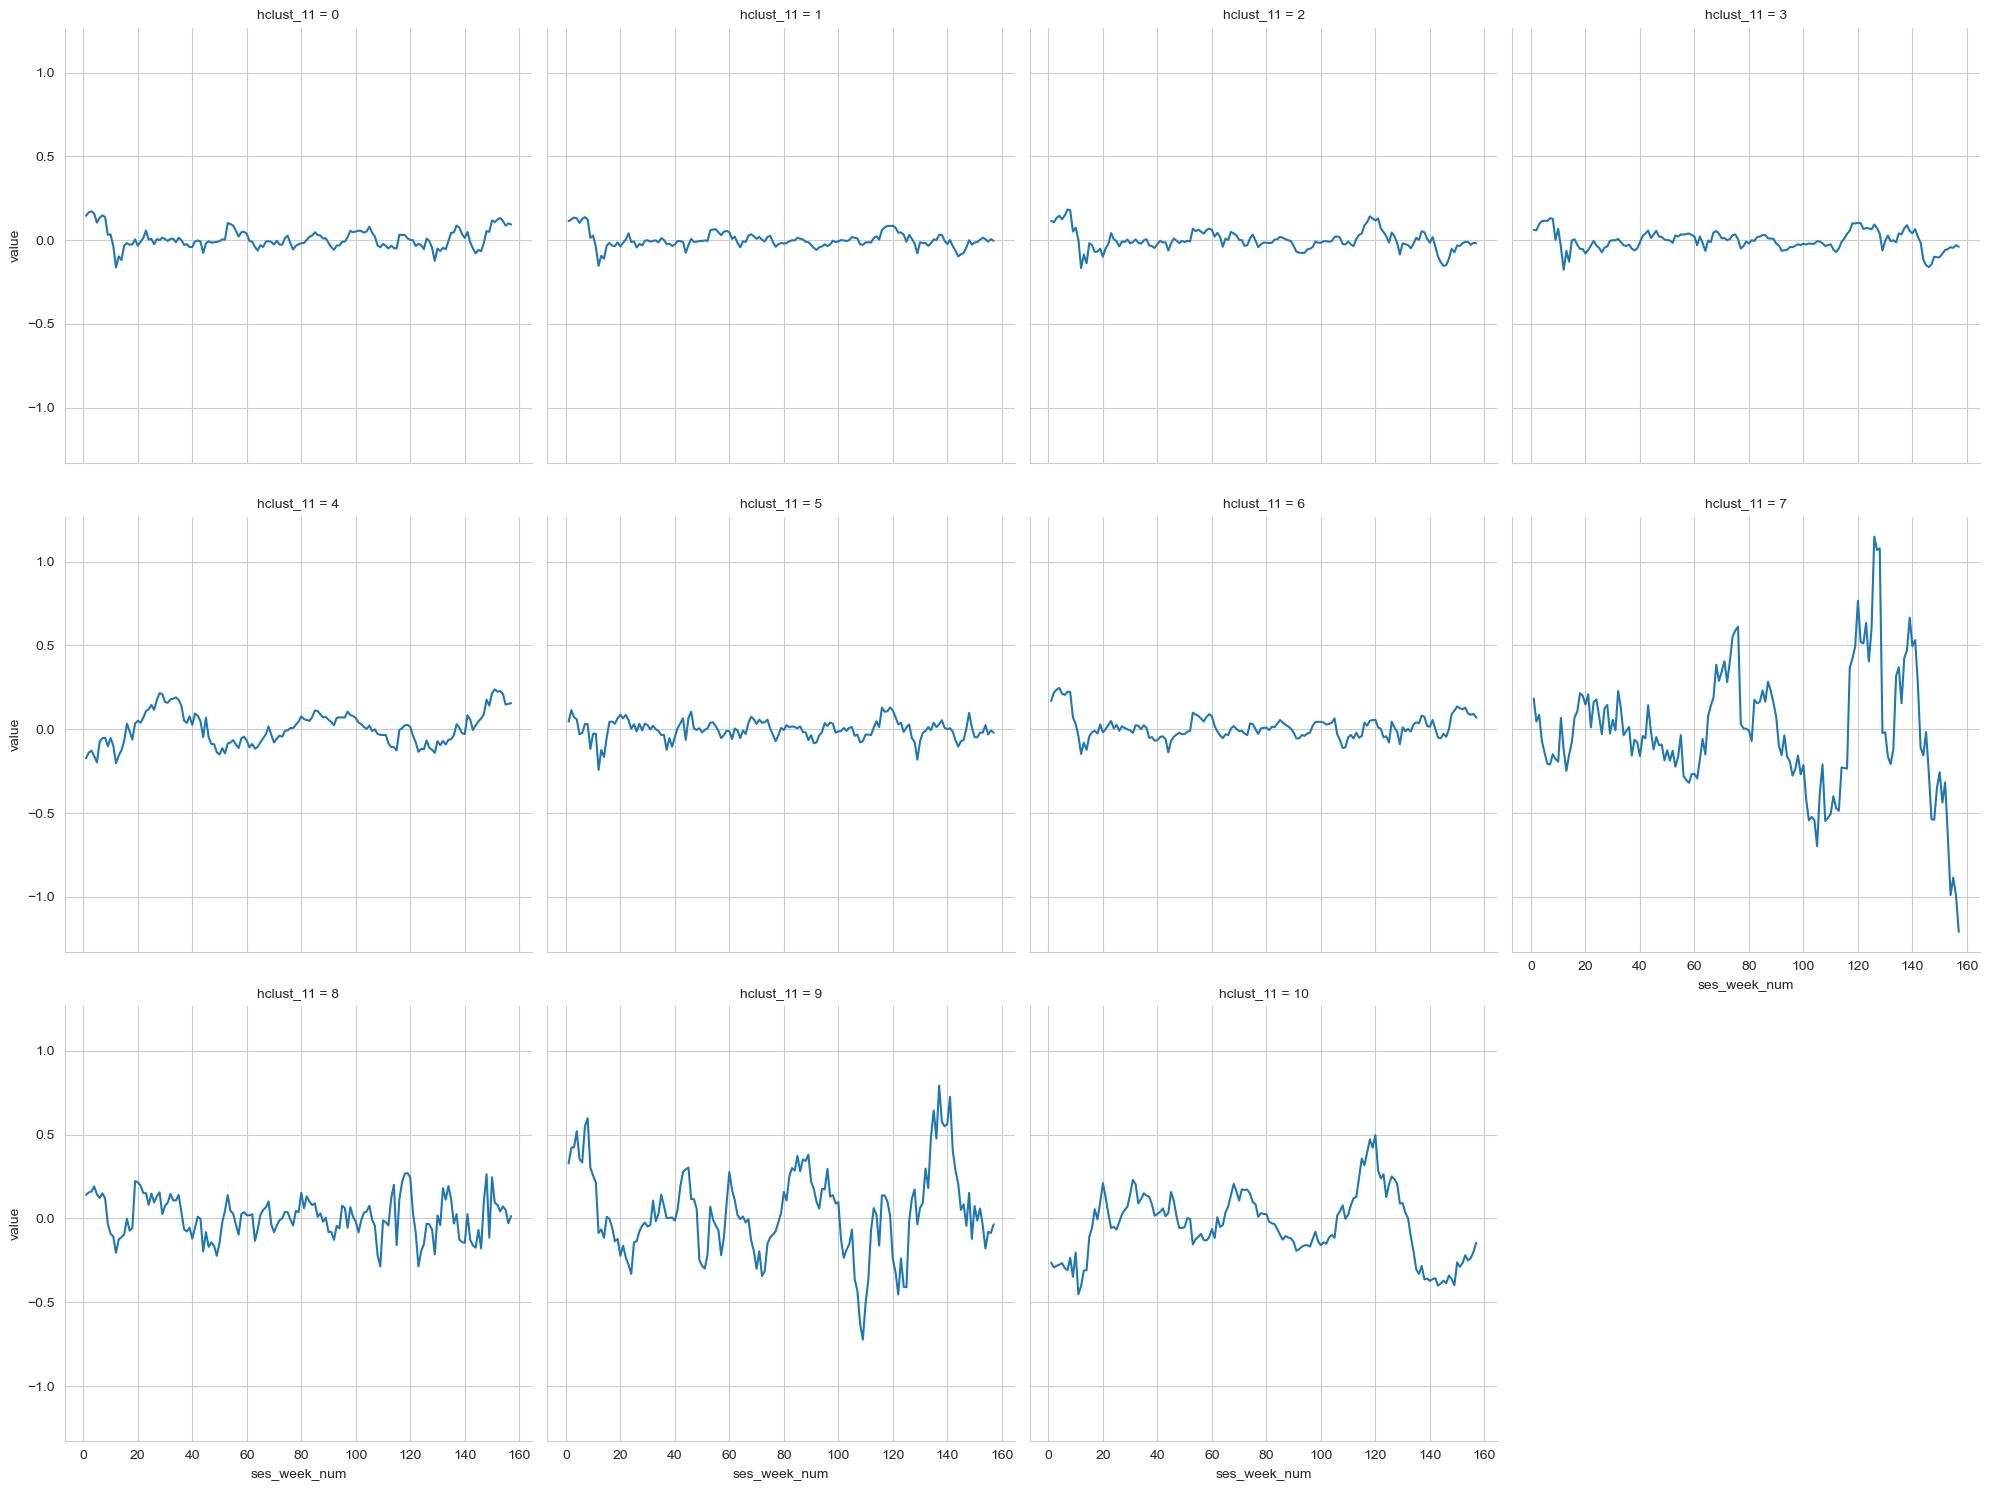

In [169]:
sns.relplot(data=pred_grid_ses_col_df_lf,
            x='ses_week_num', y='value', col='hclust_11', col_wrap=4,
           kind='line')

plt.show()

**Avg. Seasonal Value Colored by RF model Predictions**

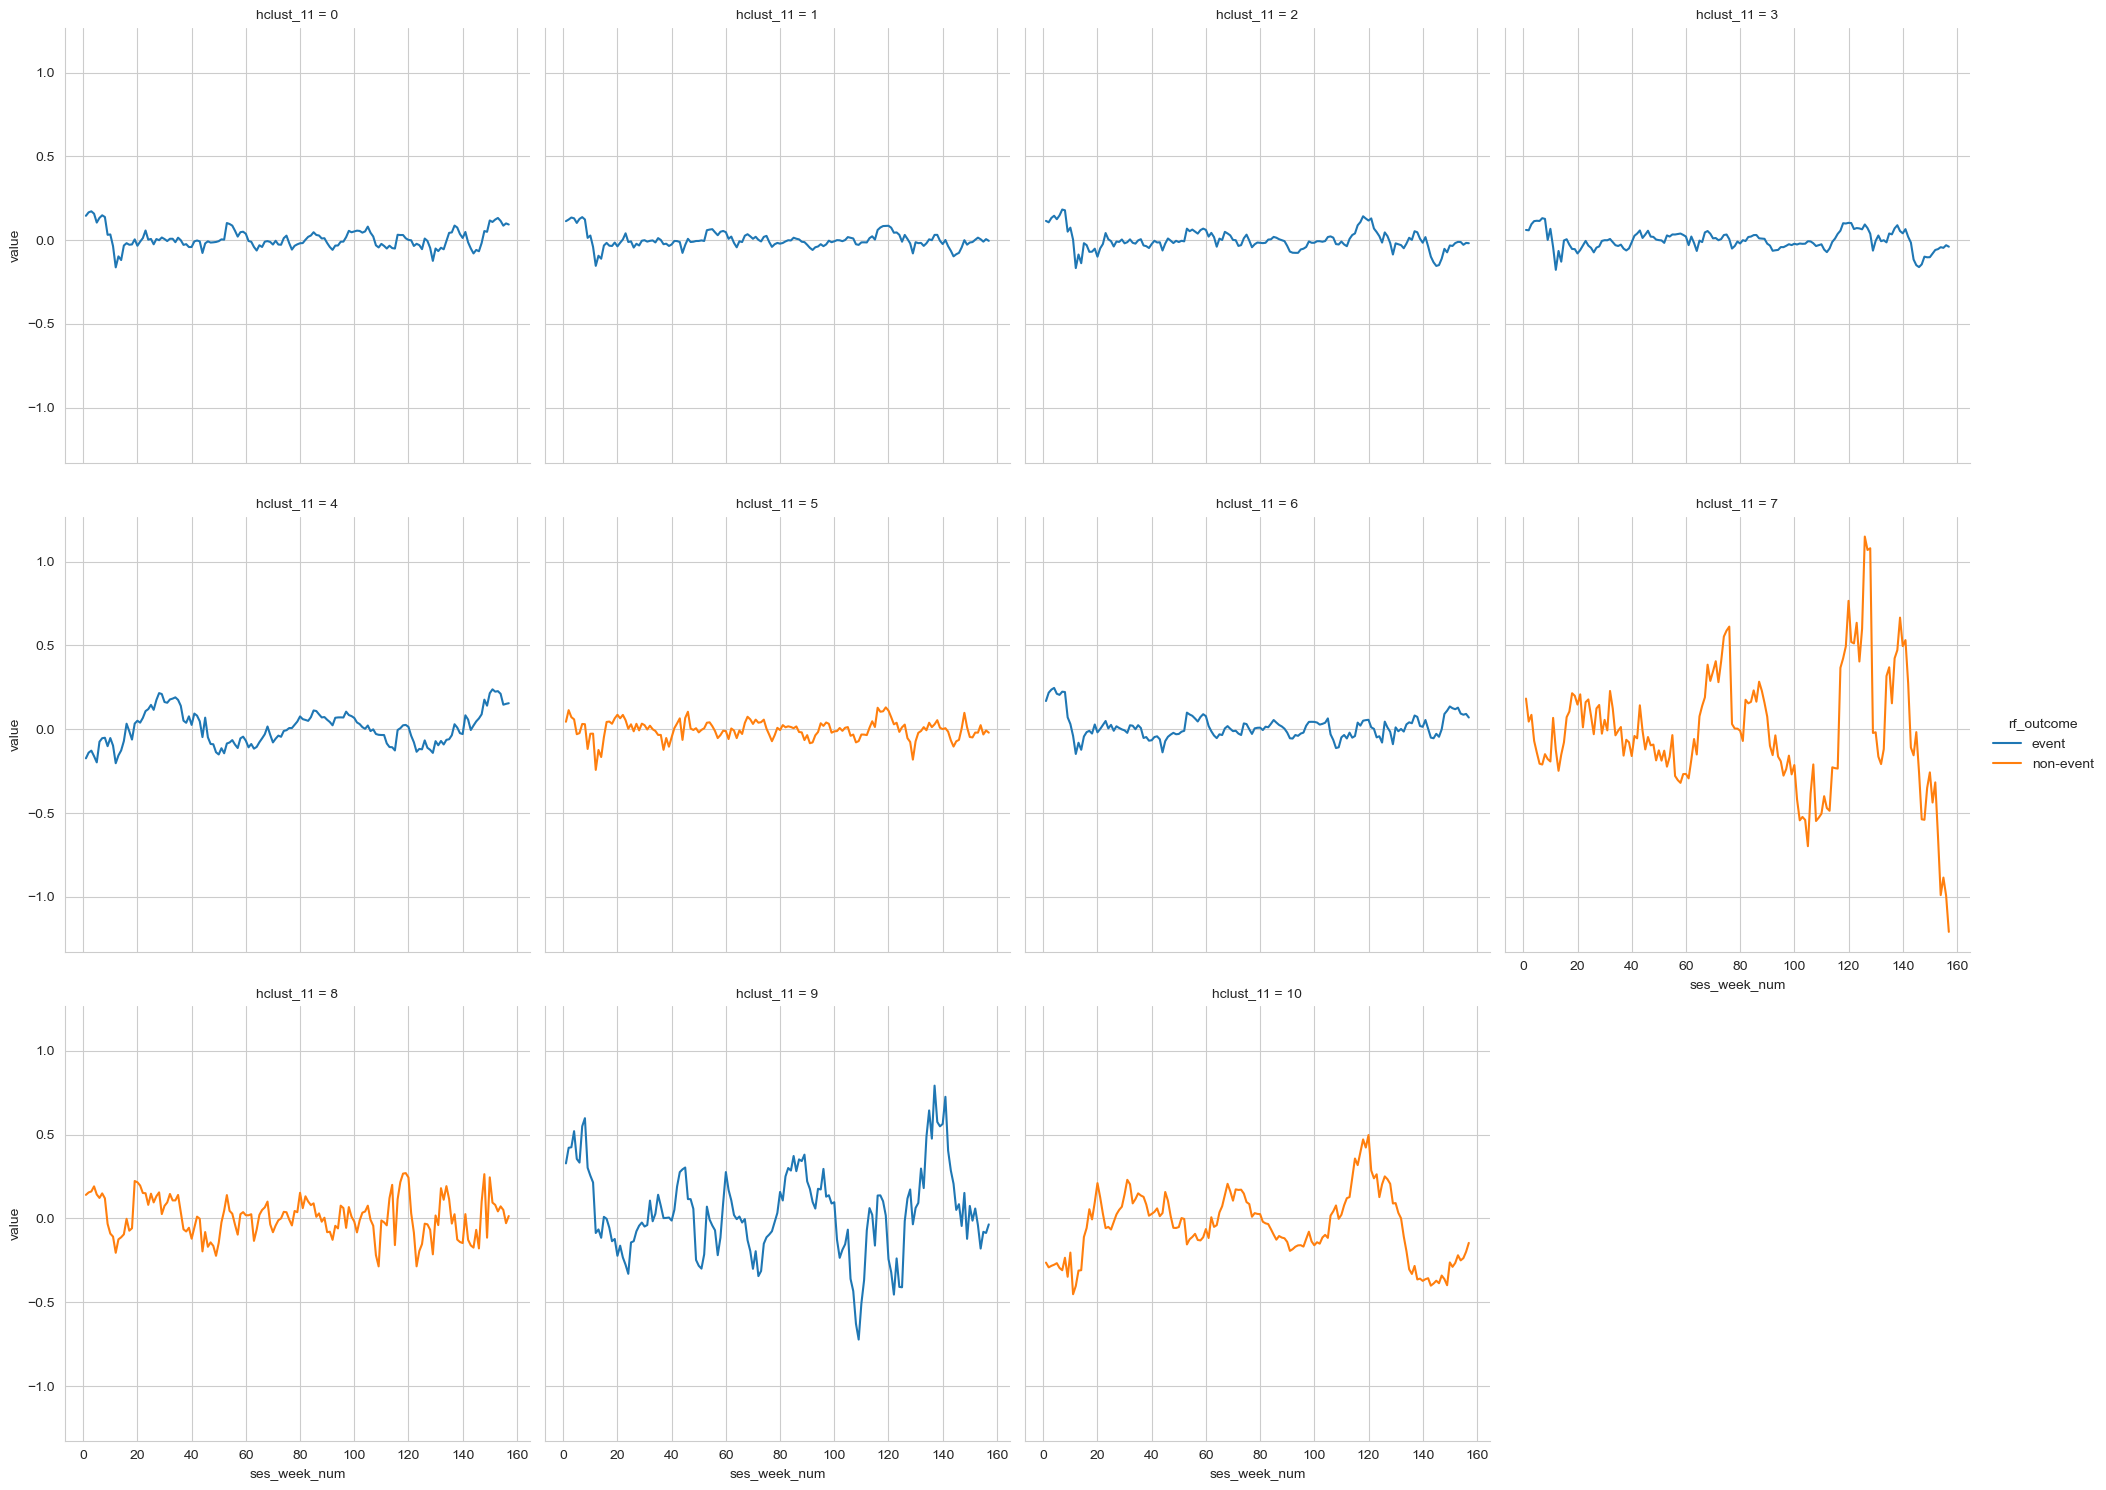

In [170]:
sns.relplot(data=pred_grid_ses_col_df_lf,
            x='ses_week_num', y='value', hue='rf_outcome', col='hclust_11', col_wrap=4,
           kind='line')

plt.show()

**Avg. Seasonal Value Colored by GBM model Predictions**

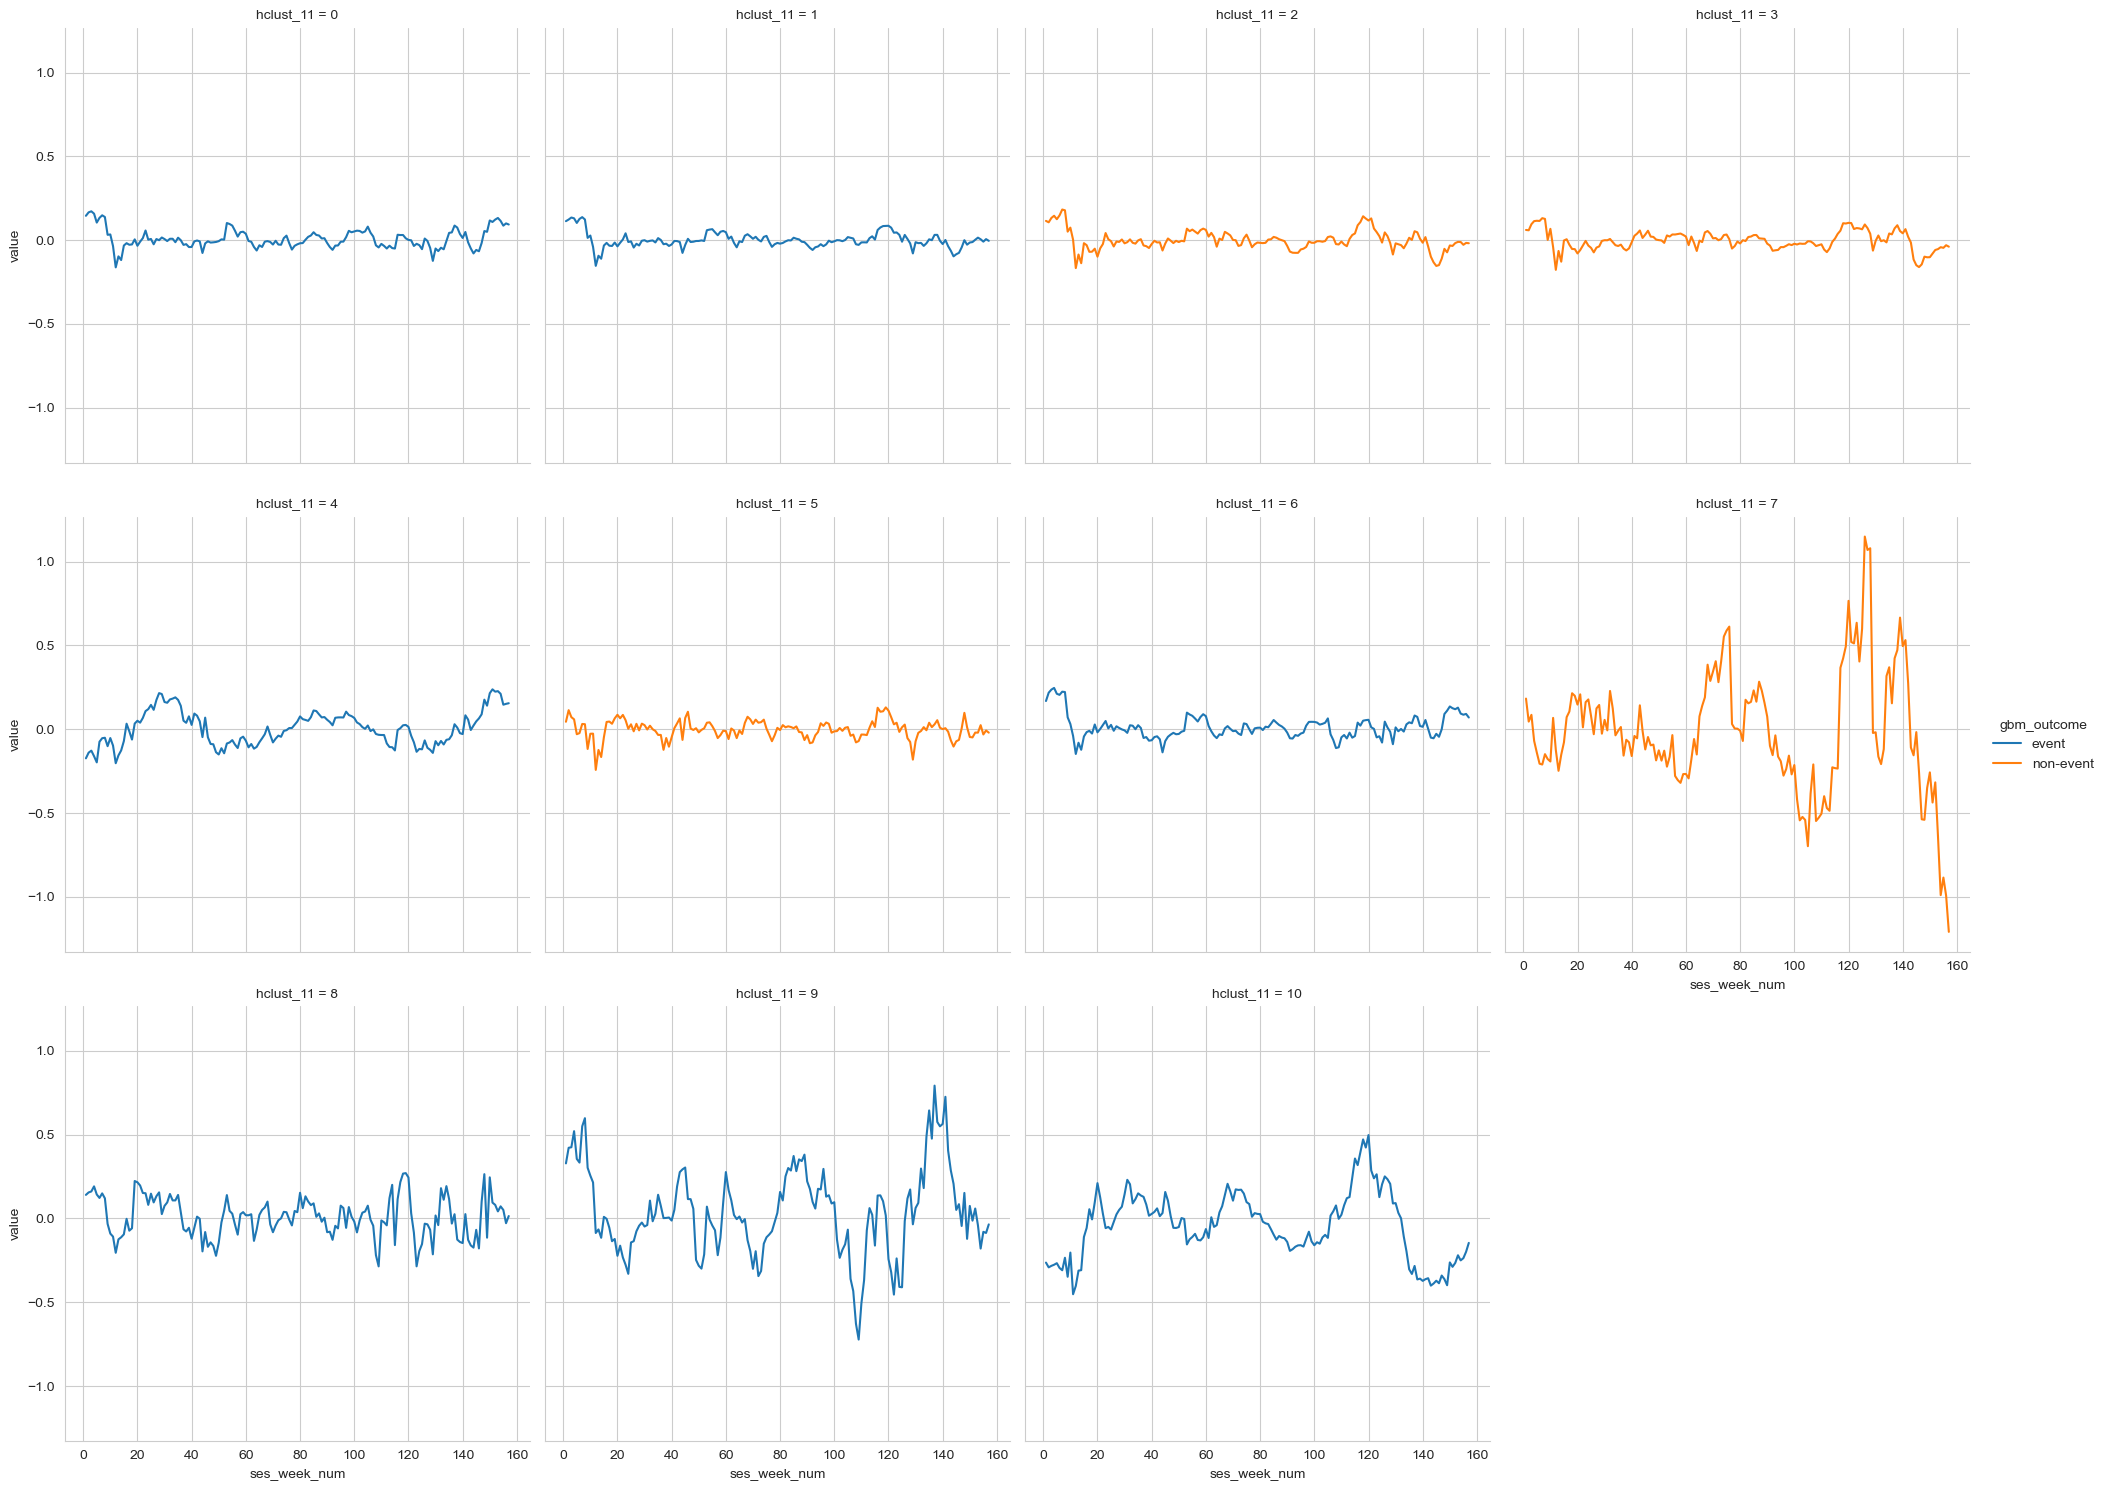

In [171]:
sns.relplot(data=pred_grid_ses_col_df_lf,
            x='ses_week_num', y='value', hue='gbm_outcome', col='hclust_11', col_wrap=4,
           kind='line')

plt.show()

**Avg. Trend Value**

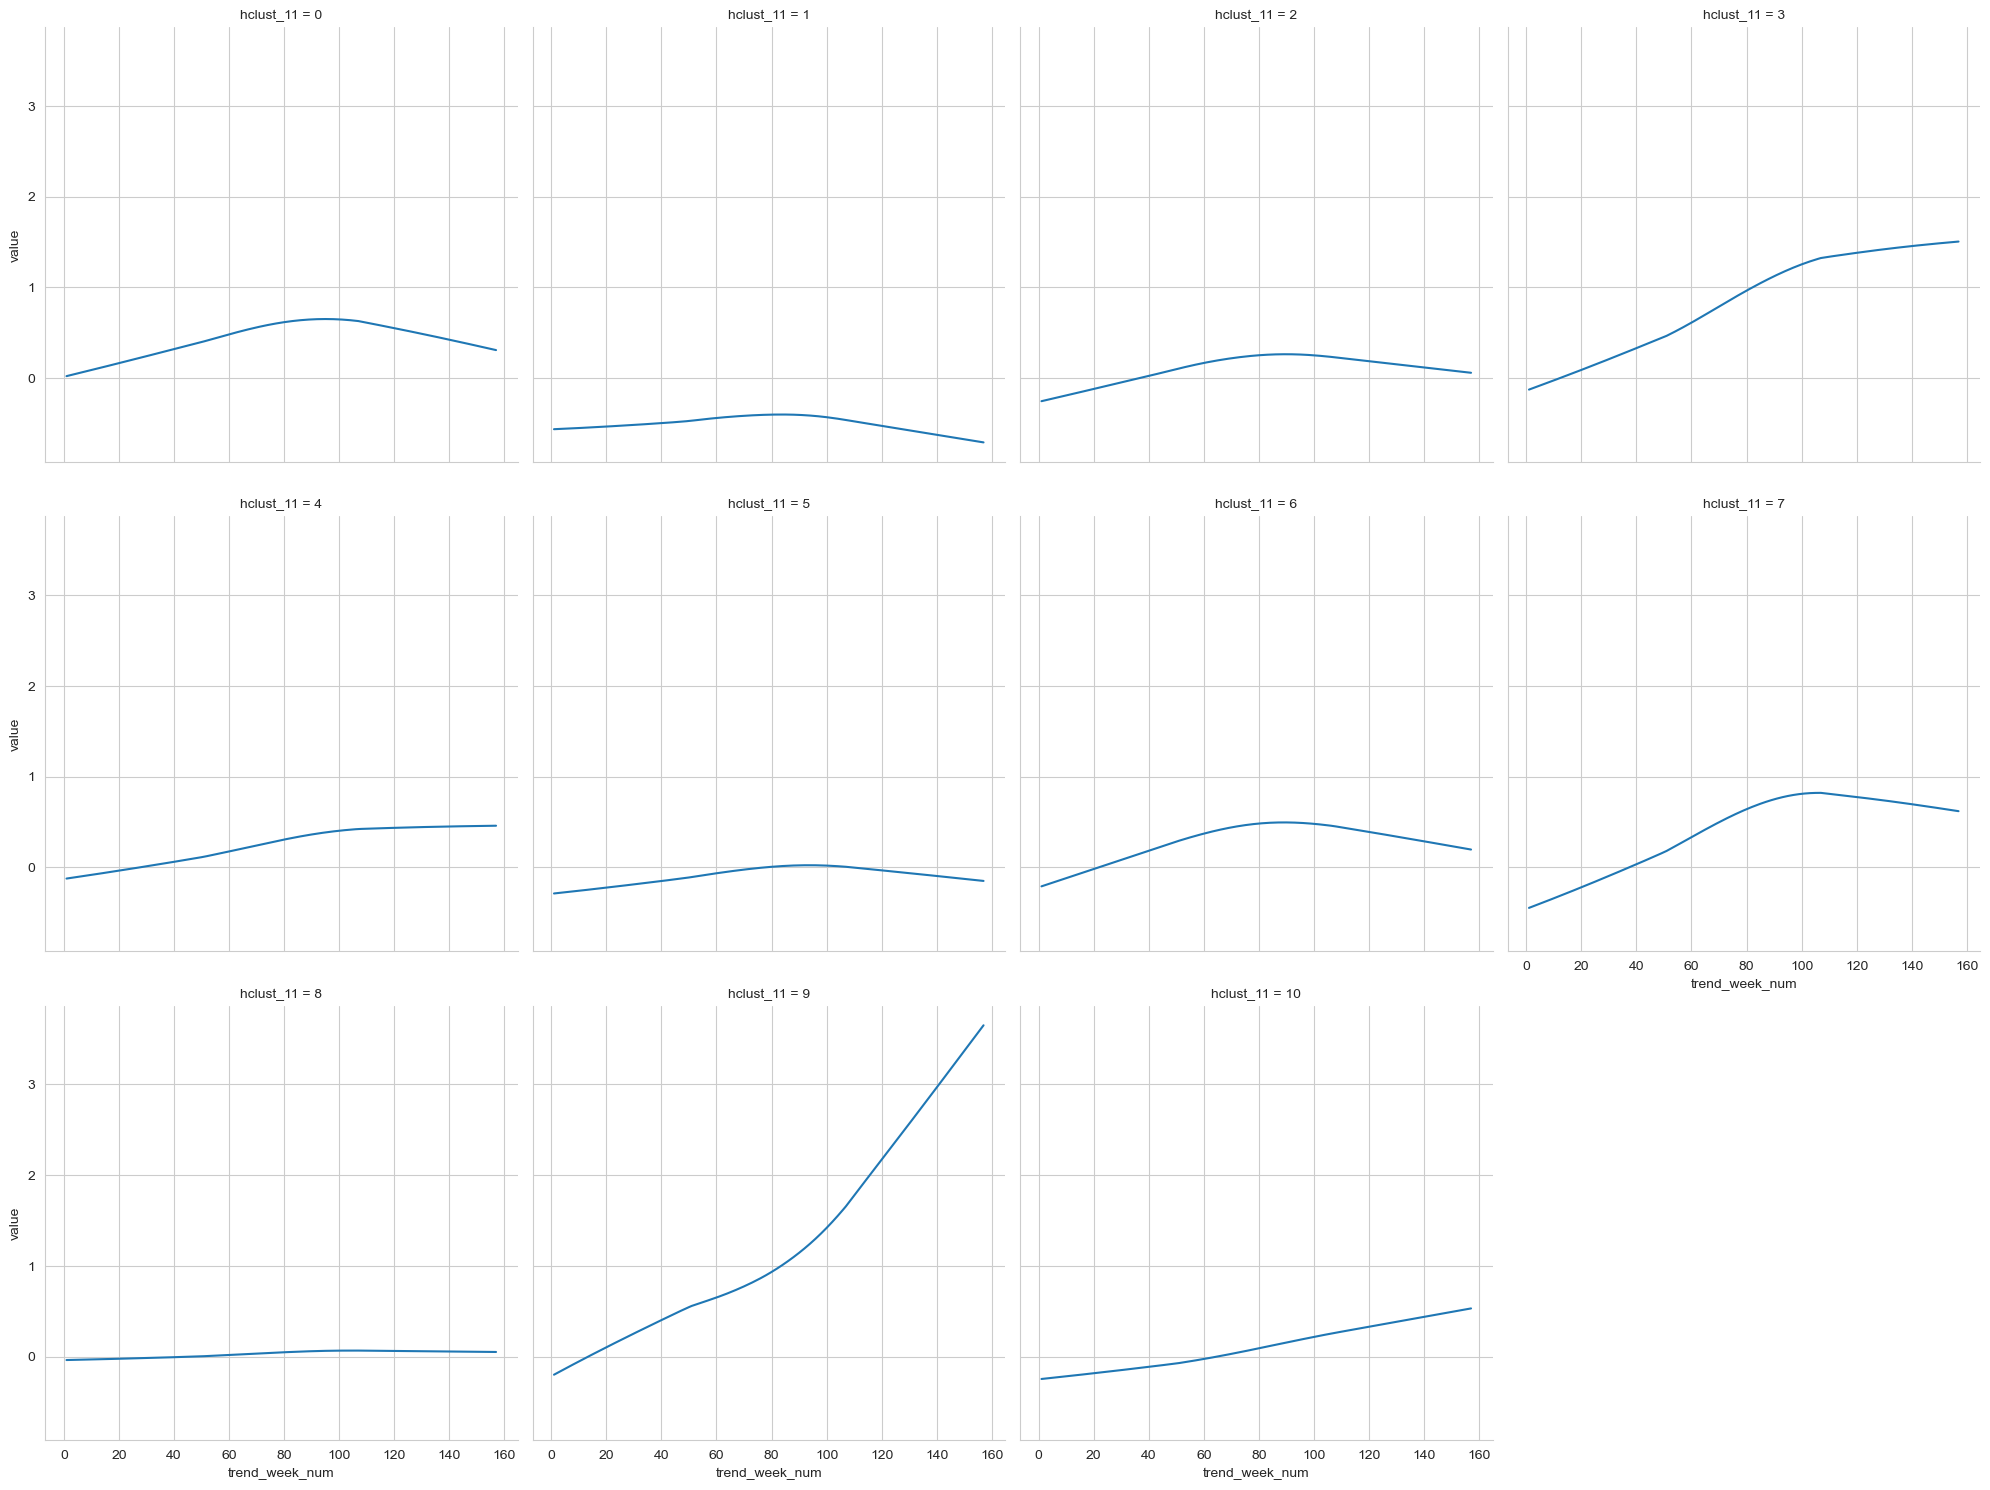

In [172]:
sns.relplot(data=pred_grid_trend_col_df_lf,
            x='trend_week_num', y='value', col='hclust_11', col_wrap=4,
           kind='line')

plt.show()

**Avg. Trend Value Colored by RF model Predictions**

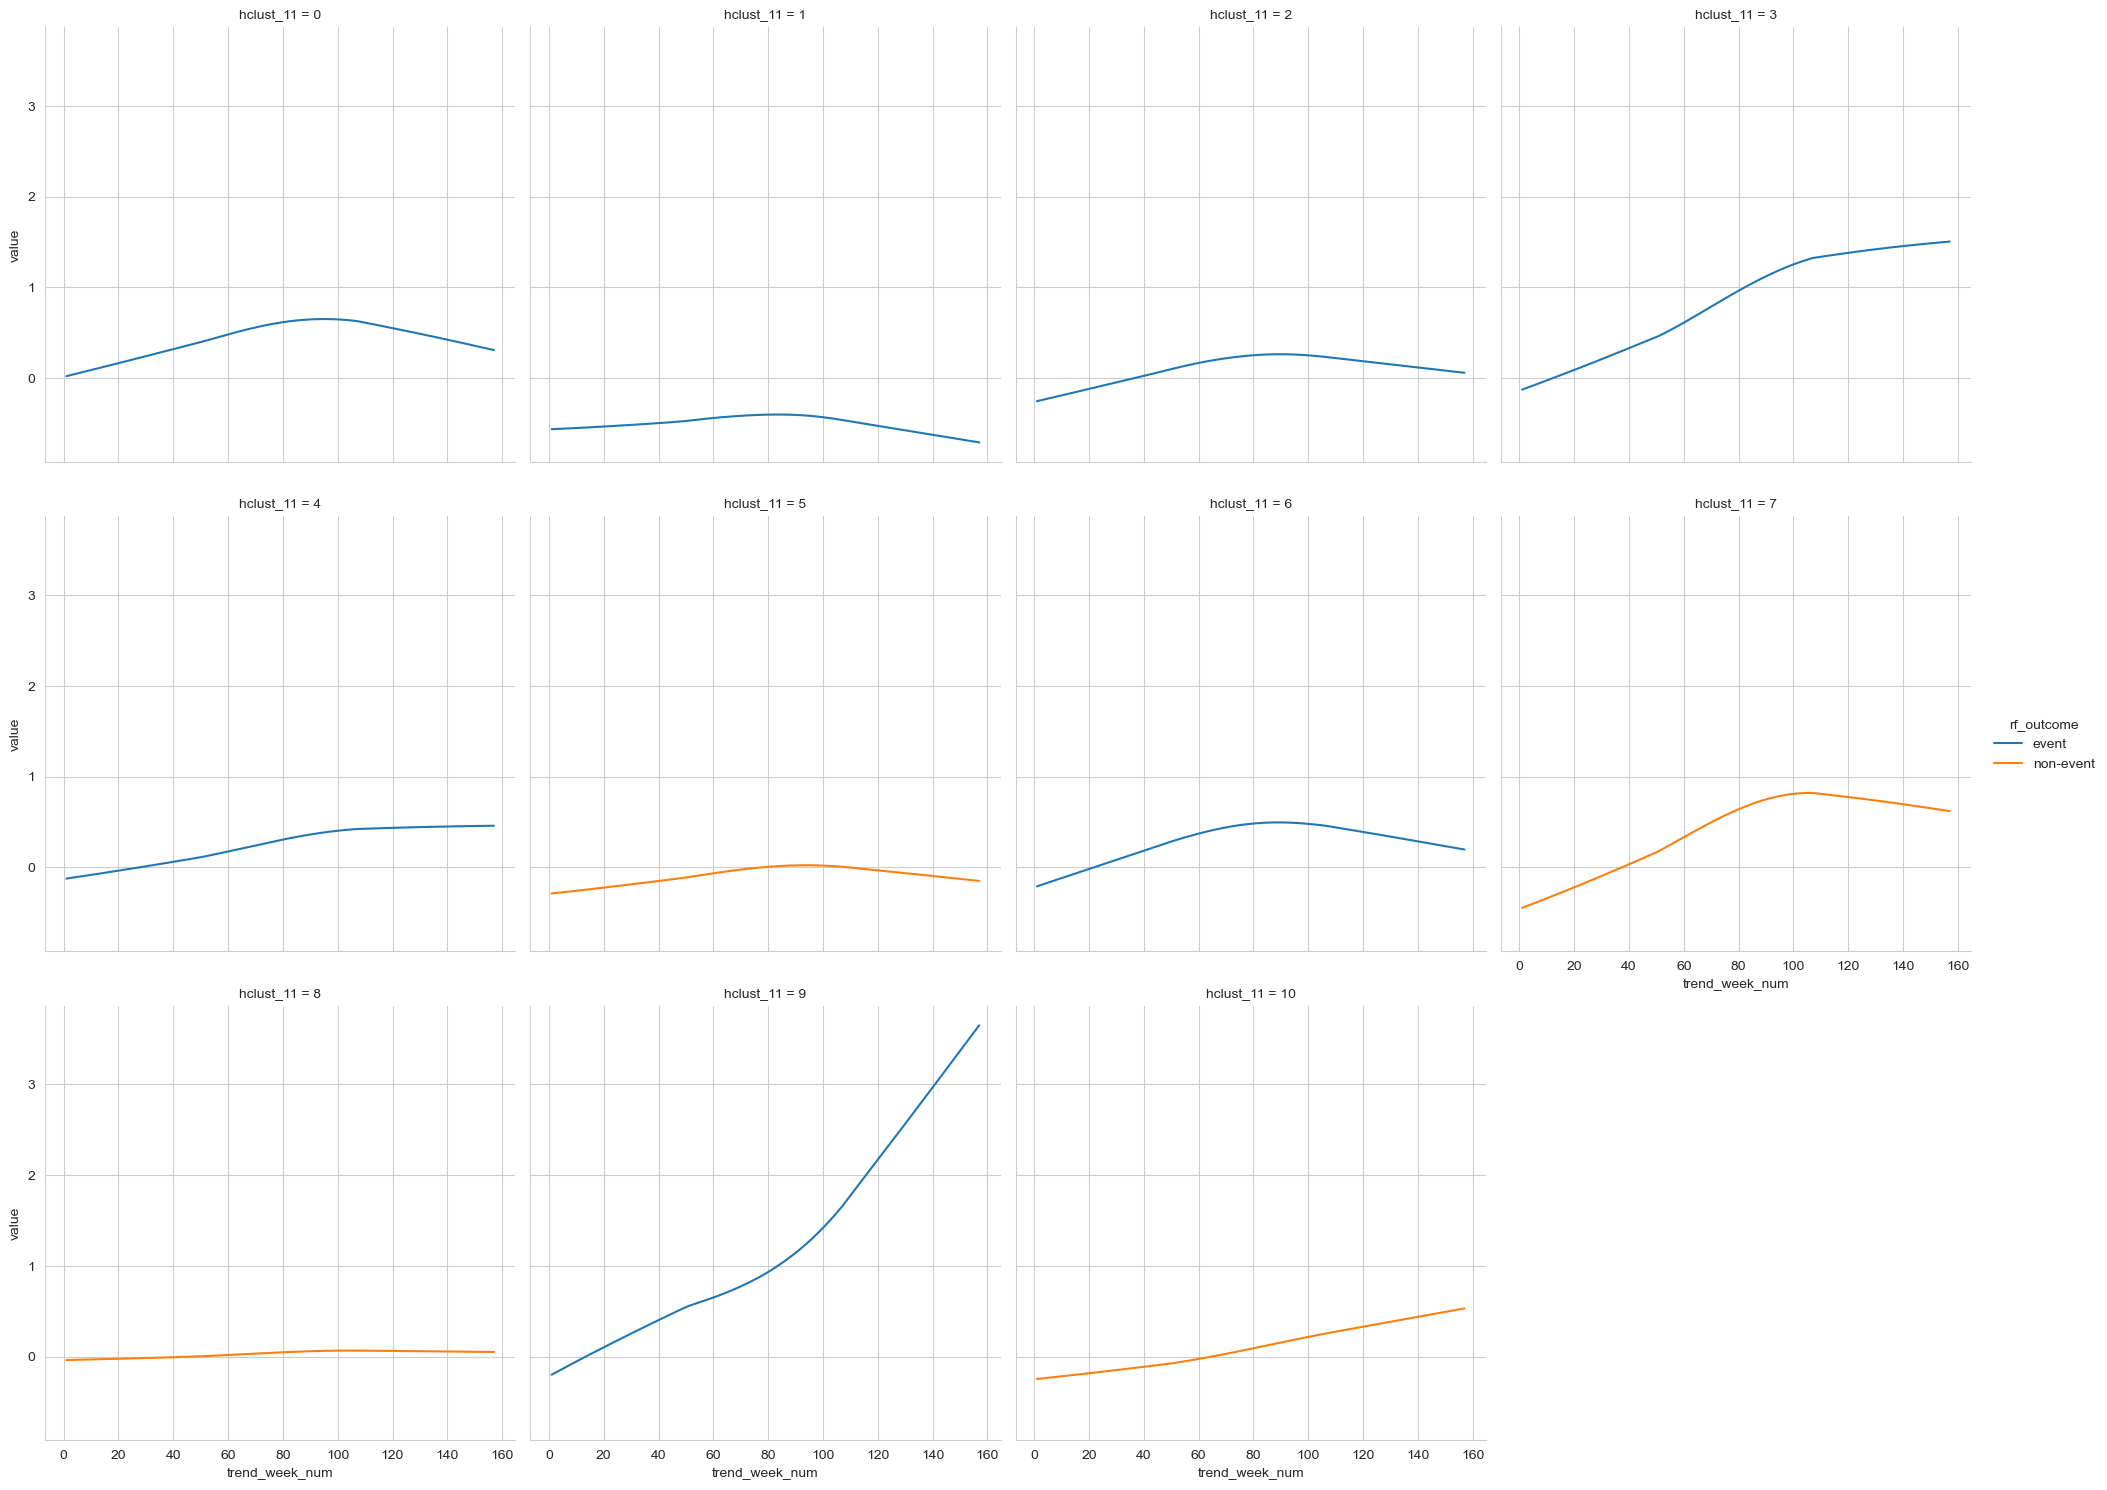

In [173]:
sns.relplot(data=pred_grid_trend_col_df_lf,
            x='trend_week_num', y='value', col='hclust_11', hue='rf_outcome', col_wrap=4,
           kind='line')

plt.show()

**Avg. Trend Value Colored by GBM model Predictions**

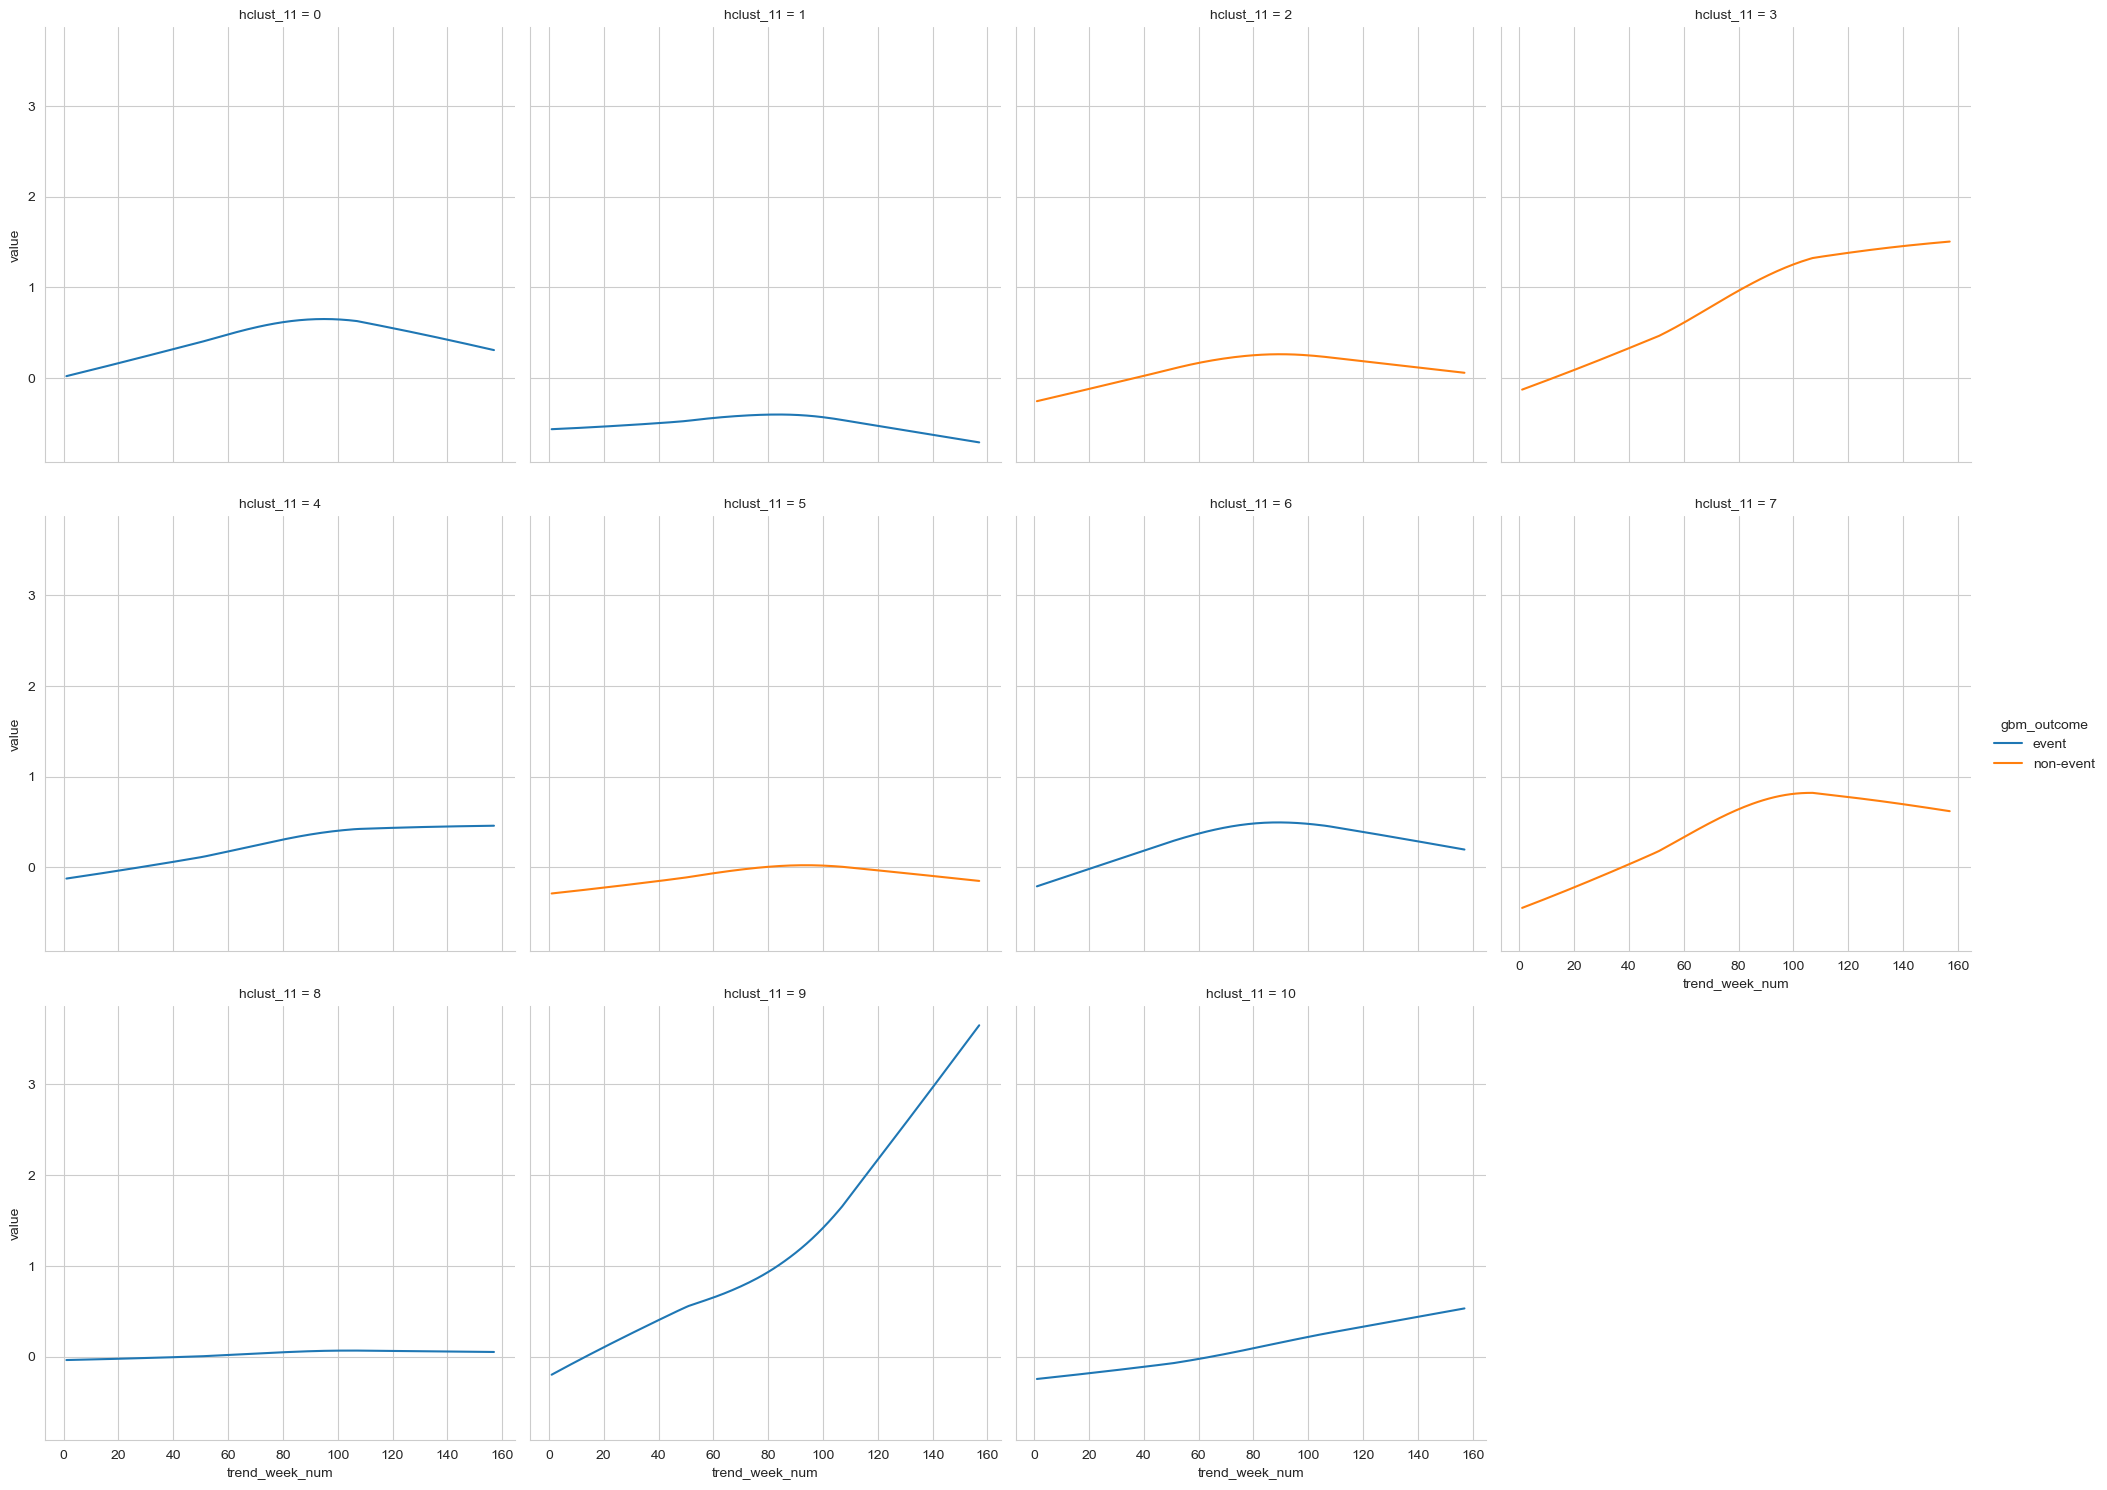

In [174]:
sns.relplot(data=pred_grid_trend_col_df_lf,
            x='trend_week_num', y='value', col='hclust_11', hue='gbm_outcome', col_wrap=4,
           kind='line')

plt.show()